In [1]:




#导入torch，用于构建神经网络

import torch
from torch import nn


import numpy as np
import pandas as pd

#记录时间
from datetime import datetime

import time


import matplotlib.pyplot as plt

from scipy.interpolate import griddata
import scipy.io


#用于重复独立实验的随机种子
import random


#获取当前文件的名称

import os



plt.rcParams['figure.dpi'] =200




In [2]:


# %%

#设置随机种子
def setup_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cuda.matmul.allow_tf32 = False# 尝试禁用这两个数据类型
        torch.backends.cudnn.allow_tf32 = False
        #torch.backends.cudnn.deterministic = True
        #torch.backends.cudnn.benchmark = False

        



        


In [3]:
def sample(min,max, N):

    x = min + (max - min) * torch.rand((N, 1), dtype = datadtype).to(device).requires_grad_(True)
   
    return x




In [4]:
class Net(nn.Module):
    def __init__(self, zysdtype,layers):
        super().__init__()#将父类的方法继承过来

        self.activation = nn.Tanh#选择tanh函数作为激活函数
        #nn.tanh是一个类，nn.Tanh（）是一个函数

        self.dtype = zysdtype

       
        self.depth = len(layers) - 1
        

        self.layers = nn.Sequential()

        for i in range(self.depth -1):
            self.layers.add_module('layer_%d' %i,
                                   nn.Linear(layers[i], layers[i+1],dtype = self.dtype))
            
            self.layers.add_module('activation_%d'%i,self.activation())

        #最后一层不通过激活函数
        self.layers.add_module("layer_%d" %(self.depth -1),nn.Linear(layers[-2], layers[-1],dtype = self.dtype))



      

    def forward(self, t,x):
        # #对输入进行归一化
        # t = 2.0*(t - t_lb)/(t_ub - t_lb) - 1.0
        # x = 2.0*(x - x_min)/(x_max - x_min) - 1.0
        H = torch.cat([t, x], 1)
        return self.layers(H)


In [5]:


# %%

class HCPINN(nn.Module):
    def __init__(self,mydtype, layers,  t_min,t_max):
        
        super(HCPINN, self).__init__()
        self.dtype = mydtype
        self.layers = layers

        self.t_min = t_min
        self.t_max = t_max



   
        #采点
        self.N_i = 2 * 1200
        self.N_b = 2 * int(1200 * (self.t_max - self.t_min))
        self.eta = 0.6
        self.N_r = 2 * int(1e4 * (self.t_max - self.t_min))
        self.N_n = int(self.N_r * self.eta )
        
        self.t_ics_batch =  sample(self.t_min,self.t_min, self.N_i)
        self.x_ics_batch =  sample(x_min,x_max, self.N_i)
       

        
        self.t_bc1_batch =  sample(self.t_min,self.t_max, self.N_b)
        self.x_bc1_batch =  sample(x_min,x_min, self.N_b)
        


        
        self.x_bc2_batch =  sample(x_max,x_max, self.N_b)
        


        #Fetch residual mini-bathes
        
        self.t_res_batch =  sample(self.t_min,self.t_max, self.N_r)
        self.x_res_batch =  sample(x_min,x_max, self.N_r)
       


        self.u_ics_batch = initial(self.x_ics_batch)



        #定义优化器
        self.net = Net(self.dtype, self.layers).to(device)
        self.iter = 0
        self.adam = torch.optim.Adam(self.parameters(), lr = 1e-3)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.adam, step_size = 1000, gamma= 0.9)
        self.optimizer = torch.optim.LBFGS(
            self.parameters(),
            lr = 1.0,
            max_iter = 10000,
            max_eval = 50000,
            history_size = 200,
            tolerance_grad = 1e-12,
            tolerance_change = 1.0 * np.finfo(float).eps,
            line_search_fn = 'strong_wolfe'
        )




    
  
    
    def net_u(self, t,x):
        u = self.net(t,x)
        return u
    
    def net_r(self, t, x):

     
        u = self.net_u(t,x)
       

        u_t = torch.autograd.grad(u, t,
                                  grad_outputs=torch.ones_like(u),
                                  create_graph= True,
                                  retain_graph=True)[0]
        
        u_x = torch.autograd.grad(u, x,
                                  grad_outputs=torch.ones_like(u),
                                  create_graph= True,
                                  retain_graph=True)[0]

        u_xx = torch.autograd.grad(u_x, x,
                                  grad_outputs=torch.ones_like(u_x),
                                  create_graph= True,
                                  retain_graph=True)[0]
        
        u_xxx = torch.autograd.grad(u_xx, x,
                                  grad_outputs=torch.ones_like(u_xx),
                                  create_graph= True,
                                  retain_graph=True)[0]
        
      

        residual = u_t + u * u_x + 0.0025*u_xxx                   
        return residual
    
    def net_b(self, t, x):

     
        u = self.net_u(t,x)
        u_x = torch.autograd.grad(u, x,
                                  grad_outputs=torch.ones_like(u),
                                  create_graph= True,
                                  retain_graph=True)[0]
        

        return u_x


    
    def closure(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()



        #Evaluate predictions
        
      
        self.u_ics_pred = self.net_u(self.t_ics_batch, self.x_ics_batch)
        self.u_bc1_pred = self.net_u(self.t_bc1_batch, self.x_bc1_batch)
        self.u_bc2_pred = self.net_u(self.t_bc1_batch, self.x_bc2_batch)
        self.ux_bc1_pred = self.net_b(self.t_bc1_batch, self.x_bc1_batch)
        self.ux_bc2_pred = self.net_b(self.t_bc1_batch, self.x_bc2_batch)

     
        self.r_pred = self.net_r(self.t_res_batch, self.x_res_batch)

        #Boundary loss and Initial loss
        self.loss_ic = torch.mean((self.u_ics_pred- self.u_ics_batch)**2 )

        self.loss_ics = self.loss_ic


        self.loss_bc1 = torch.mean((self.u_bc1_pred - self.u_bc2_pred)**2 )
        self.loss_bc2 = torch.mean((self.ux_bc1_pred -self.ux_bc2_pred)**2 )

        self.loss_bcs = self.loss_bc2 + self.loss_bc1
        

        #Residual loss
        self.loss_res = torch.mean((self.r_pred)**2 )

        #Total loss
        self.loss =  self.loss_ics + self.loss_bcs + self.loss_res 

        self.loss.backward(retain_graph=True)
        

        self.iter += 1

        



        if self.iter % 1000 == 0:
            print(f'\r{self.iter},loss:{self.loss.item():.5e},i:{self.loss_ics.item():.2e},f:{self.loss_res.item():.2e},b:{self.loss_bcs.item():.2e}')
            if self.iter < nIter:
            
                # 生成随机索引
                shuffle_indices = torch.randperm(self.N_r, device = device)

                x_new_train = sample(x_min,x_max, self.N_n)

                # 打乱张量顺序
                self.x_res_batch = self.x_res_batch[shuffle_indices]

                self.x_res_batch[0:self.N_n] = x_new_train

                t_new_train = sample(self.t_min,self.t_max, self.N_n)

                # 打乱张量顺序
                self.t_res_batch = self.t_res_batch[shuffle_indices]

                self.t_res_batch[0:self.N_n] = t_new_train

        # if self.iter < nIter and self.iter % 1000 == 0:

        #         # 生成随机索引
        #         shuffle_indices = torch.randperm(N_r, device = device)

        #         x_new_train = sample(x_min,x_max, N_n)

        #         # 打乱张量顺序
        #         self.x_res_batch = self.x_res_batch[shuffle_indices]

        #         self.x_res_batch[0:N_n] = x_new_train

        #         t_new_train = sample(self.t_min,self.t_max, N_n)

        #         # 打乱张量顺序
        #         self.t_res_batch = self.t_res_batch[shuffle_indices]

        #         self.t_res_batch[0:N_n] = t_new_train



        return self.loss
    
    def predict_u(self,X):
        t = X[:,0:1]
        x = X[:,1:2]
        #模型进入评估状态
        self.eval()
        with torch.no_grad():
            u = self.net_u(t,x).detach()
 
        return u
    




In [6]:

# %%


class HCPINN_next(nn.Module):
    def __init__(self,mydtype, layers,t_min,t_max, premodel):
        
        super(HCPINN_next, self).__init__()
        

        self.premodel = premodel
        self.pre_net =  self.premodel.net
        self.dtype = mydtype

        self.t_min = t_min
        self.t_max = t_max

        #停止第一个网络参数的训练
        for param in self.premodel.parameters():
            param.requires_grad = False

      

 

        #Initialize network weights and biases
        self.layers = layers
      

        

        
        
        #采点
        self.N_i = 100
        self.N_b = 2*int(1200 * (self.t_max - self.t_min))
        self.N_r = 2*int(1e4 * (self.t_max - self.t_min))
        self.eta = 0.6
        self.N_n = int(self.eta * self.N_r)


       
        self.t_ics_batch =  sample(self.t_min,self.t_min, self.N_i)
        self.x_ics_batch =  sample(x_min,x_max, self.N_i)
        

        
        self.t_bc1_batch =  sample(self.t_min,self.t_max, self.N_b)
        self.x_bc1_batch =  sample(x_min,x_min, self.N_b)
       

        self.x_bc2_batch =  sample(x_max,x_max, self.N_b)
        

        #Fetch residual mini-bathes
        
        self.t_res_batch =  sample(self.t_min,self.t_max, self.N_r)
        self.x_res_batch =  sample(x_min,x_max, self.N_r)
        


        
        self.u_ics_batch = self.premodel.net_u(self.t_ics_batch, self.x_ics_batch)


   


        #将分段函数加入训练
        #定义第一个控制函数
        self.param_log = []
      
    
        self.w1 =  nn.Parameter(self.t_min + (self.t_max-self.t_min) * 0.5)
        

        print("p的初始化%.3e "%(self.w1.item()))


        #定义优化器
        self.iter = 0
        self.net = Net(self.dtype, self.layers).to(device)

        self.adam = torch.optim.Adam(self.parameters(), lr = 1e-3)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.adam, step_size= 1000, gamma= 0.9)
        self.optimizer = torch.optim.LBFGS(
            self.parameters(),#间断点在LBFGS的阶段也训练
            lr = 1.0,
            max_iter = 10000,
            max_eval = 50000,
            history_size = 200,
            tolerance_grad = 1e-12,
            tolerance_change = 1.0 * np.finfo(float).eps,
            line_search_fn = 'strong_wolfe'
        )


        # # #加载上一个网络的信息
        # self.pretrained_dict = self.premodel.net.state_dict()
        # model_dict = self.net.state_dict()
        # model_dict.update(self.pretrained_dict)
        # self.net.load_state_dict(model_dict)
        # self.net.state_dict()


    
    def impact_func(self,t):
  
 
        condition1 = t <= self.t_min

        if self.w1 < self.t_max:
            t_right = self.w1
        else:
            t_right = self.t_max
      
        condition2 = t <= t_right
       

     
        B = (t - self.t_min) / (t_right - self.t_min)


        result = torch.where(condition1, torch.zeros_like(t), torch.where(condition2, -2 * B**3 + 3 * B**2, torch.ones_like(t) ) )
                                   
        return result
    
  
    



    def net_u(self, t,x):
        ww = self.impact_func(t)
        u =  (1-ww)*self.pre_net(t,x) + ww* self.net(t,x)
        return u
    
  
    
    def net_r(self, t, x):

        u = self.net_u(t,x)

        u_t = torch.autograd.grad(u, t,
                                  grad_outputs=torch.ones_like(u),
                                  create_graph= True,
                                  retain_graph=True)[0]
        
        u_x = torch.autograd.grad(u, x,
                                  grad_outputs=torch.ones_like(u),
                                  create_graph= True,
                                  retain_graph=True)[0]

        u_xx = torch.autograd.grad(u_x, x,
                                  grad_outputs=torch.ones_like(u_x),
                                  create_graph= True,
                                  retain_graph=True)[0]
        
        u_xxx = torch.autograd.grad(u_xx, x,
                                  grad_outputs=torch.ones_like(u_xx),
                                  create_graph= True,
                                  retain_graph=True)[0]
        
      

        residual = u_t + u * u_x + 0.0025*u_xxx  

                             
        return residual
    
    def net_b(self, t, x):

        u = self.net_u(t,x)

        
        u_x = torch.autograd.grad(u, x,
                                  grad_outputs=torch.ones_like(u),
                                  create_graph= True,
                                  retain_graph=True)[0]
        
       
        return u_x


    
    def closure(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        self.w1.data = torch.clamp(self.w1.data, (self.t_min).item() + 1e-3, (self.t_min+(self.t_max-self.t_min)*1.0).item()+1e-6)
       
        #Evaluate predictions
        
       

        self.u_ics_pred = self.net_u(self.t_ics_batch, self.x_ics_batch)
        self.u_bc1_pred = self.net_u(self.t_bc1_batch, self.x_bc1_batch)
        self.u_bc2_pred = self.net_u(self.t_bc1_batch, self.x_bc2_batch)
        self.ux_bc1_pred = self.net_b(self.t_bc1_batch, self.x_bc1_batch)
        self.ux_bc2_pred = self.net_b(self.t_bc1_batch, self.x_bc2_batch)

     
        self.r_pred = self.net_r(self.t_res_batch, self.x_res_batch)

        #Boundary loss and Initial loss
        self.loss_ic = torch.mean((self.u_ics_pred- self.u_ics_batch)**2 )
        self.loss_bc1 = torch.mean((self.u_bc1_pred - self.u_bc2_pred)**2 )
        self.loss_bc2 = torch.mean((self.ux_bc1_pred -self.ux_bc2_pred)**2 )

        self.loss_bcs = self.loss_bc2 + self.loss_bc1
        self.loss_ics = self.loss_ic

        #Residual loss
        self.loss_res = torch.mean((self.r_pred)**2 )

        #Total loss
        self.loss = self.loss_bcs + self.loss_res

        self.loss.backward(retain_graph=True)
        

        self.iter += 1

        
        
        self.param_log.append([self.w1.item()])
 

        if self.iter % 1000 == 0:
            print(f'\r{self.iter},loss:{self.loss.item():.5e},i:{self.loss_ics.item():.2e},f:{self.loss_res.item():.2e},b:{self.loss_bcs.item():.2e},p:{self.w1.item():.2e}')
           
            
            if self.iter < nIter :
                # 生成随机索引
            
                shuffle_indices = torch.randperm(self.N_r, device = device)

                x_new_train = sample(x_min,x_max, self.N_n)

                

                # 打乱张量顺序
                self.x_res_batch = self.x_res_batch[shuffle_indices]

                self.x_res_batch[0:self.N_n] = x_new_train

                t_new_train = sample(self.t_min,self.t_max,self.N_n)

                # 打乱张量顺序
                self.t_res_batch = self.t_res_batch[shuffle_indices]

                self.t_res_batch[0:self.N_n] = t_new_train


        # if self.iter < nIter and self.iter % 1000 == 0:

        #                 # 生成随机索引
        #                 shuffle_indices = torch.randperm(N_r, device = device)

        #                 x_new_train = sample(x_min,x_max, N_n)

        #                 # 打乱张量顺序
        #                 self.x_res_batch = self.x_res_batch[shuffle_indices]

        #                 self.x_res_batch[0:N_n] = x_new_train

        #                 t_new_train = sample(self.t_min,self.t_max, N_n)

        #                 # 打乱张量顺序
        #                 self.t_res_batch = self.t_res_batch[shuffle_indices]

        #                 self.t_res_batch[0:N_n] = t_new_train

        return self.loss
    
    def predict_u(self,X):
        t = X[:,0:1]
        x = X[:,1:2]
        self.eval()
        with torch.no_grad():
            u = self.net_u(t,x).detach()
            
        return u
    




In [7]:



# %%

# %%
#Define initial condition 

def initial(x):

   
    u = torch.cos(torch.pi * x)
    return u



In [8]:


# %%

# %%

# %%
#画出区间的图像以及求误差
def plot_error_block(model,t_min,t_max):
   
    n_min = int(t_min * num_points)
    n_max = int(t_max * num_points)
    #n_test = n_max - n_min

    t_block = t_total[n_min:n_max +1]
    T_block, X_block = torch.meshgrid(t_block, x_total, indexing='ij')

    #组装
 
    X_star_block = torch.cat((T_block.flatten()[:, None], X_block.flatten()[:,None]), dim=1)

    #引入真实的信息
    u0_star = data[:,n_min:n_max +1].T
    u_star = u0_star.flatten()[:,None]

    #网络预测的结果
    u_pred_block = model.predict_u(X_star_block)

    #计算误差
    error_u =  torch.norm(u_star - u_pred_block, p=2) /torch.norm(u_star, p=2)
    error_u1 = torch.norm(u_star - u_pred_block, p=1) / len(X_star_block)
    error_uinf = torch.norm(u_star - u_pred_block, p=float('inf'))
    
    print("\n查看区间：[%.2f,%.2f]"%(T_block.min().item(), T_block.max().item()))
    print("\nRelative L2 error_u: {:.5e}".format(error_u))
    print("\nRelative L1 error_u: {:.5e}".format(error_u1))
    print("\nRelative Linf error_u: {:.5e}".format(error_uinf))
    


    return u_pred_block, error_u.item(), error_u1.item(), error_uinf.item()



In [9]:
def plot_func(t, func1,p_log):
    fig = plt.figure(figsize=(15, 3),dpi=200)
    plt.subplot(1, 2, 1)
    plt.plot(t.cpu().detach().numpy(), func1(t).cpu().detach().numpy())
    plt.title("eta(t)")


    plt.subplot(1, 2, 2)
    plt.plot(range(0, len(p_log)), p_log)
    plt.title("p_log")
    plt.show()
   

In [10]:


def train_block(t_min, t_max, num_block,train_num):
    train_time = 0
    models = []
    error_total = []
   
    t_block = torch.linspace(t_min, t_max, num_block + 1).to(device)

    train_time_total = []
    for i in range(num_block):
        
        print('训练区间：[%.2f,%.2f]'%(t_block[i], t_block[i+1]))

        
        if i == 0:
            
            model = HCPINN(datadtype,layers, t_block[i],t_block[i+1])

                #进行训练
            start_time = time.time()
            print('\n\t====Begin Adam====')
            for adam_iter in range(nIter):
                    model.closure()
                    model.adam.step()
                    model.scheduler.step()
            print('\n\t====Begin LBFSG====')
            model.optimizer.step(model.closure)
            block_time =  (time.time() - start_time)/60
            
          


        else:

            model = HCPINN_next(datadtype, layers,t_block[i], t_block[i+1],   models[-1])



            #进行训练
            start_time = time.time()
            print('\n\t====Begin Adam====')
            for adam_iter in range(nIter):
                    model.closure()
                    model.adam.step()
                    model.scheduler.step()
            print('\n\t====Begin LBFSG====')
            model.optimizer.step(model.closure)
            block_time =  (time.time() - start_time)/60

            #画出铰链函数
            plot_func(torch.linspace(t_min, t_max + 0.1, 10000).to(device), model.impact_func,model.param_log)
            
           

            
            #保存当前参数的变化
            df_param_log = pd.DataFrame(model.param_log, columns=['p'])

         

            # 将DataFrame保存为Excel文件
            df_param_log.to_excel(folder_path + "/第%d次训练_[%.2f,%.2f]_p_log.xlsx"%(train_num, t_block[i],t_block[i+1]), index=False)

     

          
        
        train_time_total.append(block_time)
        print('区间[%.2f,%.2f]的训练时间：%.2f min(s)'%(t_block[i],t_block[i+1] ,(time.time() - start_time) /60)) 
        print("Final loss: %.5e,Total iteration: %d"%(model.loss.item(),model.iter))

        
        
        #保存网络
        torch.save(model.state_dict(),folder_path + "/第%d次训练_[%.2f,%.2f].pth"%(train_num, t_block[i],t_block[i+1]))

        _, *error_block= plot_error_block(model,t_block[i], t_block[i +1])
  

        #记录实验结果
        models.append(model)
        error_total.append(error_block)
    train_time = sum(train_time_total)
    train_time_total.append(train_time)
    print('\n#小区间个数：%d，总训练时长:%.2f  min(s)'%(num_block,train_time))

    return models,error_total, train_time_total



# %%


In [11]:



# %%
def u_pred_whole(models, t_min, t_max,num_block,train_times_num):

    
    t_block = torch.linspace(t_min, t_max, num_block + 1).to(device)


    
    n_min = int(t_min * num_points)
    n_max = int(t_max * num_points)
    n_mid = n_max - n_min

    t_total_now = t_total[n_min:n_max +1]



    
    T_total_now,X_total_now = torch.meshgrid(t_total_now,x_total, indexing='ij')

    X_star_total_now = torch.cat((T_total_now.flatten()[:,None],X_total_now.flatten()[:,None]), dim=1)

    u0_star =  data[:,n_min:n_max +1].T
    u_star = u0_star.flatten()[:,None]

    u_combine = []

    for block_index in range(num_block):
        #对每个小区间进行更加详细的计算
        n_min_now = int(t_block[block_index] * num_points)
        n_max_now = int(t_block[block_index +1] * num_points)

        if block_index ==0:
            
            tt = t_total_now[n_min_now : n_max_now+1]

        else:
            tt = t_total_now[n_min_now+1 :  n_max_now+1]


        T_pred_now,X_pred_now = torch.meshgrid(tt,x_total, indexing='ij')

        XX_star_pred = torch.cat((T_pred_now.flatten()[:,None],X_pred_now.flatten()[:,None]), dim=1)
      

        u_pred = models[block_index].predict_u(XX_star_pred)
      
        u_combine.append(u_pred)
 
    
    u_com = torch.cat(u_combine, dim=0)



    erroru = torch.norm(u_star - u_com, p=2) / torch.norm(u_star, p=2)
    erroru1 = torch.norm(u_star - u_com,p=1)/len(X_star_total_now)
    erroruinf = torch.norm(u_star - u_com, p=float('inf'))
    error_whole = [erroru.item(), erroru1.item(), erroruinf.item()]
    print('\n#查看区间[%.2f,%.2f]:'%(t_min, t_max))
    print('#error L2:{:.5e}'.format(erroru))
    print('#error L1:{:.5e}'.format(erroru1))
    print('#error Linf:{:.5e}'.format(erroruinf))

    U_pred = griddata(X_star_total_now.cpu(), u_com.cpu().flatten(), (T_total_now.cpu(),X_total_now.cpu()),method = 'cubic')
    U_star = griddata(X_star_total_now.cpu(), u0_star.cpu().flatten(), (T_total_now.cpu(), X_total_now.cpu()), method='cubic')
   
   
    #画出全区间的图像
    fig = plt.figure(figsize=(18, 5),dpi=200)
    plt.subplot(1, 3, 1)
    plt.pcolor(T_total_now.cpu(), X_total_now.cpu(), U_star, cmap='jet')
    plt.colorbar()
    plt.xlabel('$t$')
    plt.ylabel('$x$')
    plt.title(r'Reference solution')
    plt.tight_layout()

    plt.subplot(1, 3, 2)
    plt.pcolor(T_total_now.cpu(), X_total_now.cpu(), U_pred, cmap='jet')
    plt.colorbar()
    plt.xlabel('$t$')
    plt.ylabel('$x$')
    plt.title(r'Predicted solution')
    plt.tight_layout()

    plt.subplot(1, 3, 3)
    plt.pcolor(T_total_now.cpu(), X_total_now.cpu(), abs(U_star - U_pred), cmap='jet')
    plt.colorbar()
    plt.xlabel('$t$')
    plt.ylabel('$x$')
    plt.title('Point-wise Error')
    plt.tight_layout()
    plt.savefig(folder_path + '/区间个数%d_第%d次训练_U_pred.pdf'%(num_block,train_times_num))
    #plt.show()  
    plt.close()

    #画出固定t，u的snap
    fig = plt.figure(figsize=(18, 5),dpi=200)
    plt.subplot(1, 3, 1)
    plt.plot(x_total.cpu(), U_star[0,:], 'r-',linewidth = 2.5,label= 'Reference')
    plt.plot(x_total.cpu(), U_pred[0,:], 'b--',linewidth = 2.5,label= 'Prediction')
    plt.xlabel('$x$')
    plt.legend()
    plt.title('t = %.2f'%(t_total_now[0]))
    plt.tight_layout()

    plt.subplot(1, 3, 2)
    plt.plot(x_total.cpu(), U_star[int(n_mid/2),:], 'r-',linewidth = 2.5,label= 'Reference')
    plt.plot(x_total.cpu(), U_pred[int(n_mid/2),:], 'b--',linewidth = 2.5,label= 'Prediction')
    plt.xlabel('$x$')
    plt.legend()
    plt.title('t = %.2f'%(t_total_now[int(n_mid/2)]))
    plt.tight_layout()


    plt.subplot(1, 3, 3)
    plt.plot(x_total.cpu(), U_star[n_mid,:], 'r-',linewidth = 2.5,label= 'Reference')
    plt.plot(x_total.cpu(), U_pred[n_mid,:], 'b--',linewidth = 2.5,label= 'Prediction')
    plt.xlabel('$x$')
    plt.legend()
    plt.title('t = %.2f'%(t_total_now[n_mid]))
    plt.tight_layout()
    plt.savefig(folder_path + '/区间个数%d_第%d次训练_u_snap.pdf'%(num_block,train_times_num))
    #plt.show()
    plt.close()

    return u_com, error_whole




# %%


In [12]:



#定义超参数
datadtype = torch.float32

#CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device( "cpu")

print(f'Using {device} to train...')
print(f'The code is trained at {datetime.now()}')




notebook_name =  'result'
print(notebook_name)


Using cuda to train...
The code is trained at 2025-01-19 17:50:39.158501
result


In [13]:

import shutil
# 定义文件夹路径
folder_path = notebook_name

# 如果文件夹存在，先删除
if os.path.exists(folder_path):
    
    shutil.rmtree(folder_path)
    print(f"文件夹 '{folder_path}' 已删除。")

# 重新创建文件夹
os.makedirs(folder_path)
print(f"文件夹 '{folder_path}' 已重新创建。")



文件夹 'result' 已重新创建。


In [14]:


# %%

t_min, t_max = 0.0, 1
x_min, x_max = -1, 1



#导入数据
num_points = 200

data_source = scipy.io.loadmat("D:/02_master/课题/硬约束/实验代码/kdv_long.mat")


data = data_source['usol']
t_total = data_source['t'].flatten()[:,None]
x_total = data_source['x'].flatten()[:,None]
data = torch.tensor(data, dtype = datadtype).to(device)
t_total = torch.tensor(t_total, dtype = datadtype).to(device).squeeze()
x_total = torch.tensor(x_total, dtype = datadtype).to(device).squeeze()


#定义独立重复实验次数以及小区间个数


num_block_start = 4
num_block_end = 4
train_times = 5



num_neural = 50


layers = [2, num_neural, num_neural, num_neural,  1]


nIter = 5000




In [15]:


# %%

names = ['erroruL2', 'erroru1', 'erroruinf','train_time']


-----**区间个数：4, 第1次训练, 随机种子: 797**-----
训练区间：[0.00,0.25]

	====Begin Adam====


d:\SoftWare\Anaconda\env\torch_gpu\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


1000,loss:4.33613e-03,i:1.63e-03,f:2.36e-03,b:3.48e-04
2000,loss:2.02065e-03,i:7.69e-04,f:1.16e-03,b:9.28e-05
3000,loss:2.01962e-03,i:5.02e-04,f:1.02e-03,b:4.93e-04
4000,loss:3.19712e-03,i:3.96e-04,f:1.18e-03,b:1.62e-03
5000,loss:7.08676e-04,i:2.24e-04,f:4.36e-04,b:4.88e-05

	====Begin LBFSG====
6000,loss:3.50575e-05,i:8.42e-06,f:2.61e-05,b:5.12e-07
7000,loss:1.65748e-05,i:2.79e-06,f:1.25e-05,b:1.31e-06
8000,loss:1.05584e-05,i:2.27e-06,f:7.52e-06,b:7.73e-07
9000,loss:7.36336e-06,i:1.57e-06,f:5.08e-06,b:7.12e-07
10000,loss:4.87019e-06,i:1.28e-06,f:2.92e-06,b:6.70e-07
区间[0.00,0.25]的训练时间：4.91 min(s)
Final loss: 4.60386e-06,Total iteration: 10281

查看区间：[0.00,0.25]

Relative L2 error_u: 1.96371e-03

Relative L1 error_u: 1.11131e-03

Relative Linf error_u: 3.76636e-03
训练区间：[0.25,0.50]
p的初始化3.750e-01 

	====Begin Adam====
1000,loss:1.68546e-01,i:0.00e+00,f:1.68e-01,b:2.05e-04,p:3.99e-01
2000,loss:3.51758e-02,i:0.00e+00,f:3.51e-02,b:8.75e-05,p:3.90e-01
3000,loss:3.56205e-02,i:0.00e+00,f:3.54e-

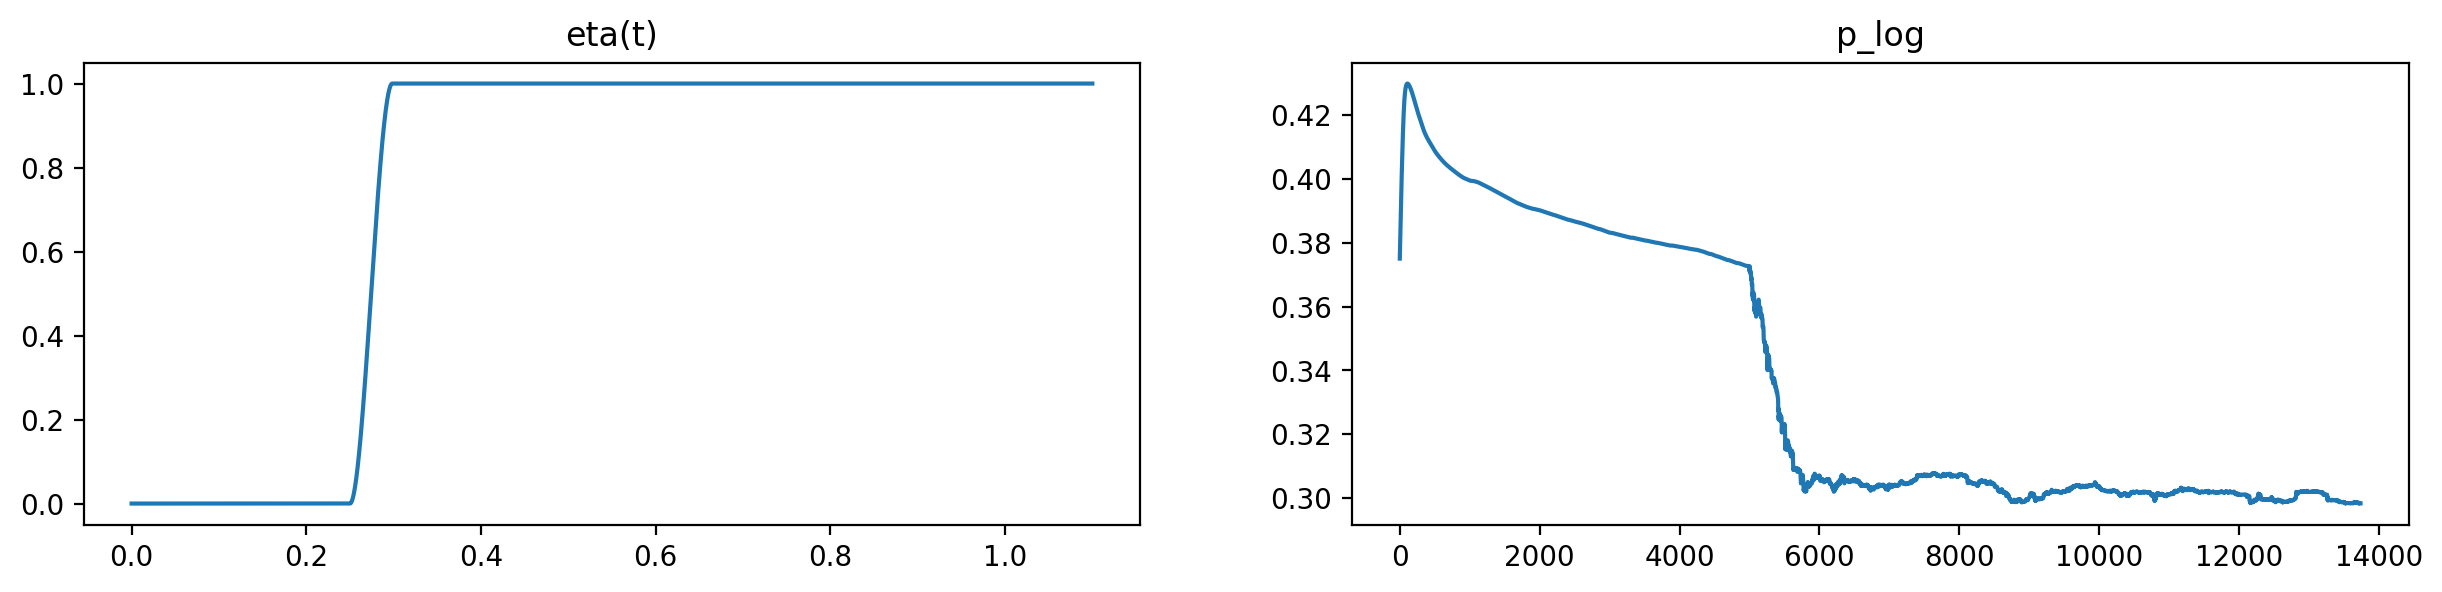

区间[0.25,0.50]的训练时间：10.05 min(s)
Final loss: 4.23465e-04,Total iteration: 13740

查看区间：[0.25,0.50]

Relative L2 error_u: 3.88884e-03

Relative L1 error_u: 2.09057e-03

Relative Linf error_u: 1.11495e-02
训练区间：[0.50,0.75]
p的初始化6.250e-01 

	====Begin Adam====
1000,loss:2.14130e-01,i:0.00e+00,f:2.11e-01,b:2.81e-03,p:7.17e-01
2000,loss:5.61629e-02,i:0.00e+00,f:5.60e-02,b:1.97e-04,p:7.07e-01
3000,loss:3.27200e-02,i:0.00e+00,f:3.24e-02,b:3.59e-04,p:6.86e-01
4000,loss:2.70008e-02,i:0.00e+00,f:2.67e-02,b:2.87e-04,p:6.67e-01
5000,loss:2.17350e-02,i:0.00e+00,f:2.15e-02,b:2.05e-04,p:6.55e-01

	====Begin LBFSG====
6000,loss:2.80978e-03,i:0.00e+00,f:2.74e-03,b:7.16e-05,p:5.62e-01
7000,loss:1.35554e-03,i:0.00e+00,f:1.27e-03,b:8.42e-05,p:5.41e-01
8000,loss:8.47014e-04,i:0.00e+00,f:7.83e-04,b:6.41e-05,p:5.28e-01
9000,loss:6.08635e-04,i:0.00e+00,f:5.72e-04,b:3.65e-05,p:5.21e-01
10000,loss:4.33457e-04,i:0.00e+00,f:4.05e-04,b:2.83e-05,p:5.20e-01


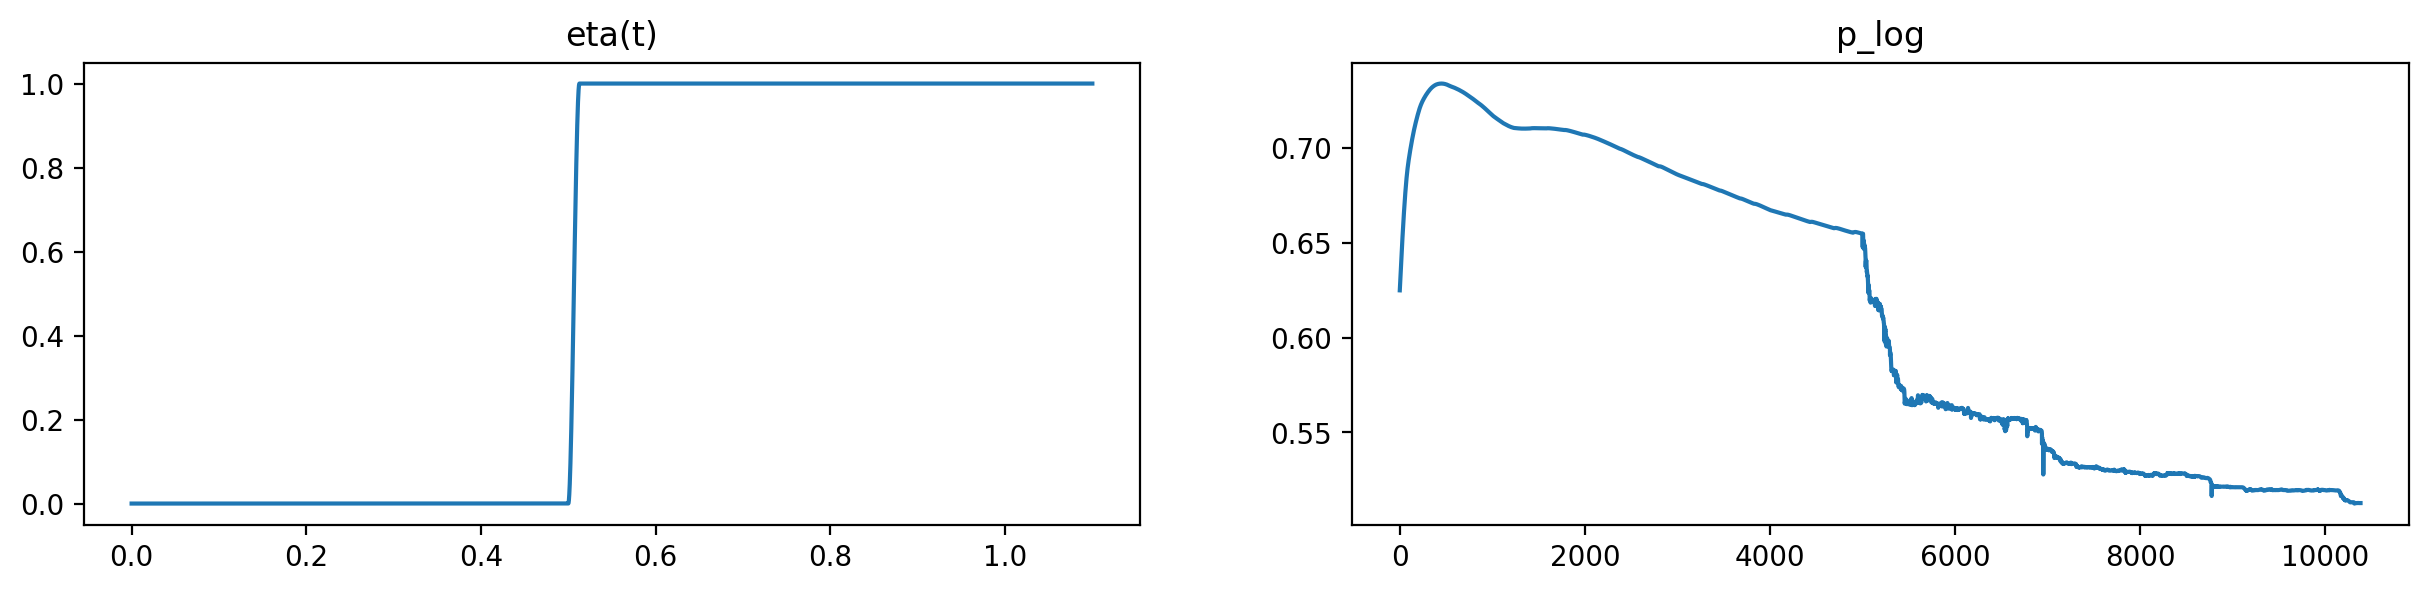

区间[0.50,0.75]的训练时间：7.01 min(s)
Final loss: 3.86438e-04,Total iteration: 10380

查看区间：[0.50,0.75]

Relative L2 error_u: 5.19216e-03

Relative L1 error_u: 2.61697e-03

Relative Linf error_u: 1.51865e-02
训练区间：[0.75,1.00]
p的初始化8.750e-01 

	====Begin Adam====
1000,loss:6.35641e-01,i:0.00e+00,f:6.05e-01,b:3.06e-02,p:1.00e+00
2000,loss:1.29850e-01,i:0.00e+00,f:9.88e-02,b:3.10e-02,p:1.00e+00
3000,loss:9.00350e-02,i:0.00e+00,f:6.08e-02,b:2.93e-02,p:1.00e+00
4000,loss:7.78859e-02,i:0.00e+00,f:5.13e-02,b:2.66e-02,p:1.00e+00
5000,loss:7.38614e-02,i:0.00e+00,f:5.00e-02,b:2.39e-02,p:1.00e+00

	====Begin LBFSG====
6000,loss:1.08541e-02,i:0.00e+00,f:8.20e-03,b:2.65e-03,p:1.00e+00
7000,loss:6.74729e-03,i:0.00e+00,f:5.03e-03,b:1.72e-03,p:1.00e+00
8000,loss:4.65228e-03,i:0.00e+00,f:3.07e-03,b:1.58e-03,p:1.00e+00
9000,loss:2.96019e-03,i:0.00e+00,f:2.10e-03,b:8.63e-04,p:1.00e+00
10000,loss:1.91305e-03,i:0.00e+00,f:1.52e-03,b:3.97e-04,p:1.00e+00
11000,loss:1.42530e-03,i:0.00e+00,f:1.12e-03,b:3.03e-04,p:1.00e

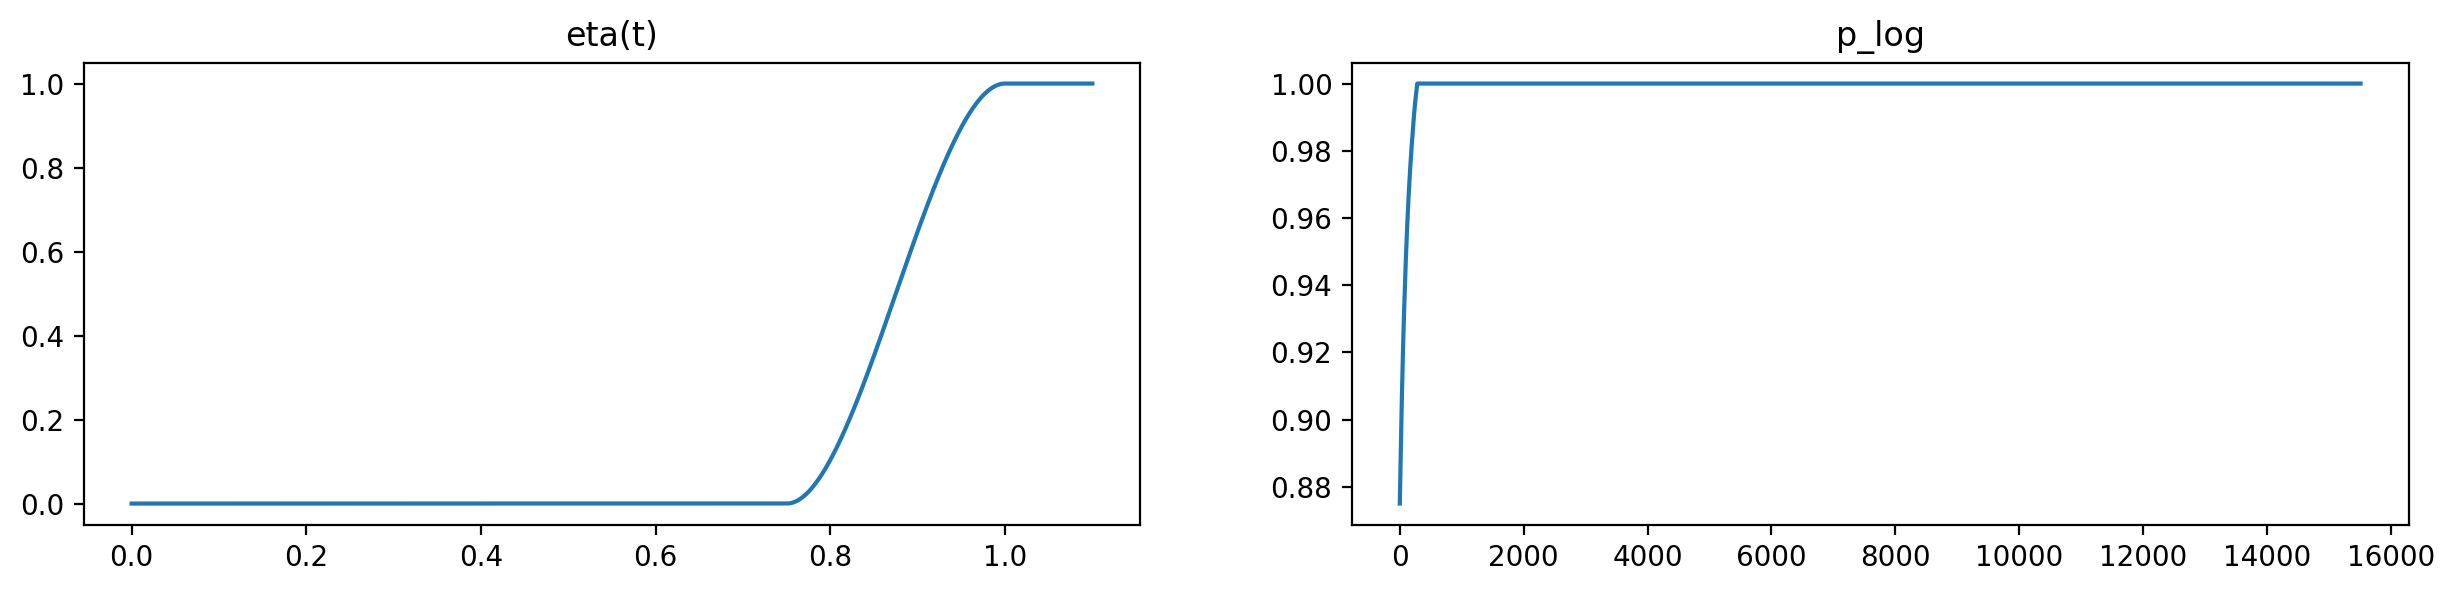

区间[0.75,1.00]的训练时间：11.85 min(s)
Final loss: 7.04642e-04,Total iteration: 15509

查看区间：[0.75,1.00]

Relative L2 error_u: 1.11056e-02

Relative L1 error_u: 5.10865e-03

Relative Linf error_u: 3.91979e-02

#小区间个数：4，总训练时长:33.80  min(s)

#查看区间[0.00,1.00]:
#error L2:6.52530e-03
#error L1:2.73836e-03
#error Linf:3.91979e-02
-----**区间个数：4, 第2次训练, 随机种子: 3059**-----
训练区间：[0.00,0.25]

	====Begin Adam====
1000,loss:1.61251e-02,i:7.10e-03,f:7.22e-03,b:1.80e-03
2000,loss:5.48766e-03,i:2.63e-03,f:2.74e-03,b:1.15e-04
3000,loss:3.46740e-03,i:1.62e-03,f:1.74e-03,b:1.11e-04
4000,loss:2.28775e-03,i:1.03e-03,f:1.17e-03,b:8.85e-05
5000,loss:1.26183e-03,i:4.73e-04,f:7.29e-04,b:5.95e-05

	====Begin LBFSG====
6000,loss:5.91792e-05,i:1.74e-05,f:3.96e-05,b:2.19e-06
7000,loss:3.48628e-05,i:1.16e-05,f:1.99e-05,b:3.42e-06
8000,loss:2.11564e-05,i:5.68e-06,f:1.35e-05,b:1.96e-06
9000,loss:1.42578e-05,i:3.37e-06,f:9.60e-06,b:1.30e-06
10000,loss:9.70512e-06,i:1.81e-06,f:6.93e-06,b:9.64e-07
11000,loss:6.89323e-06,i:1.23e-

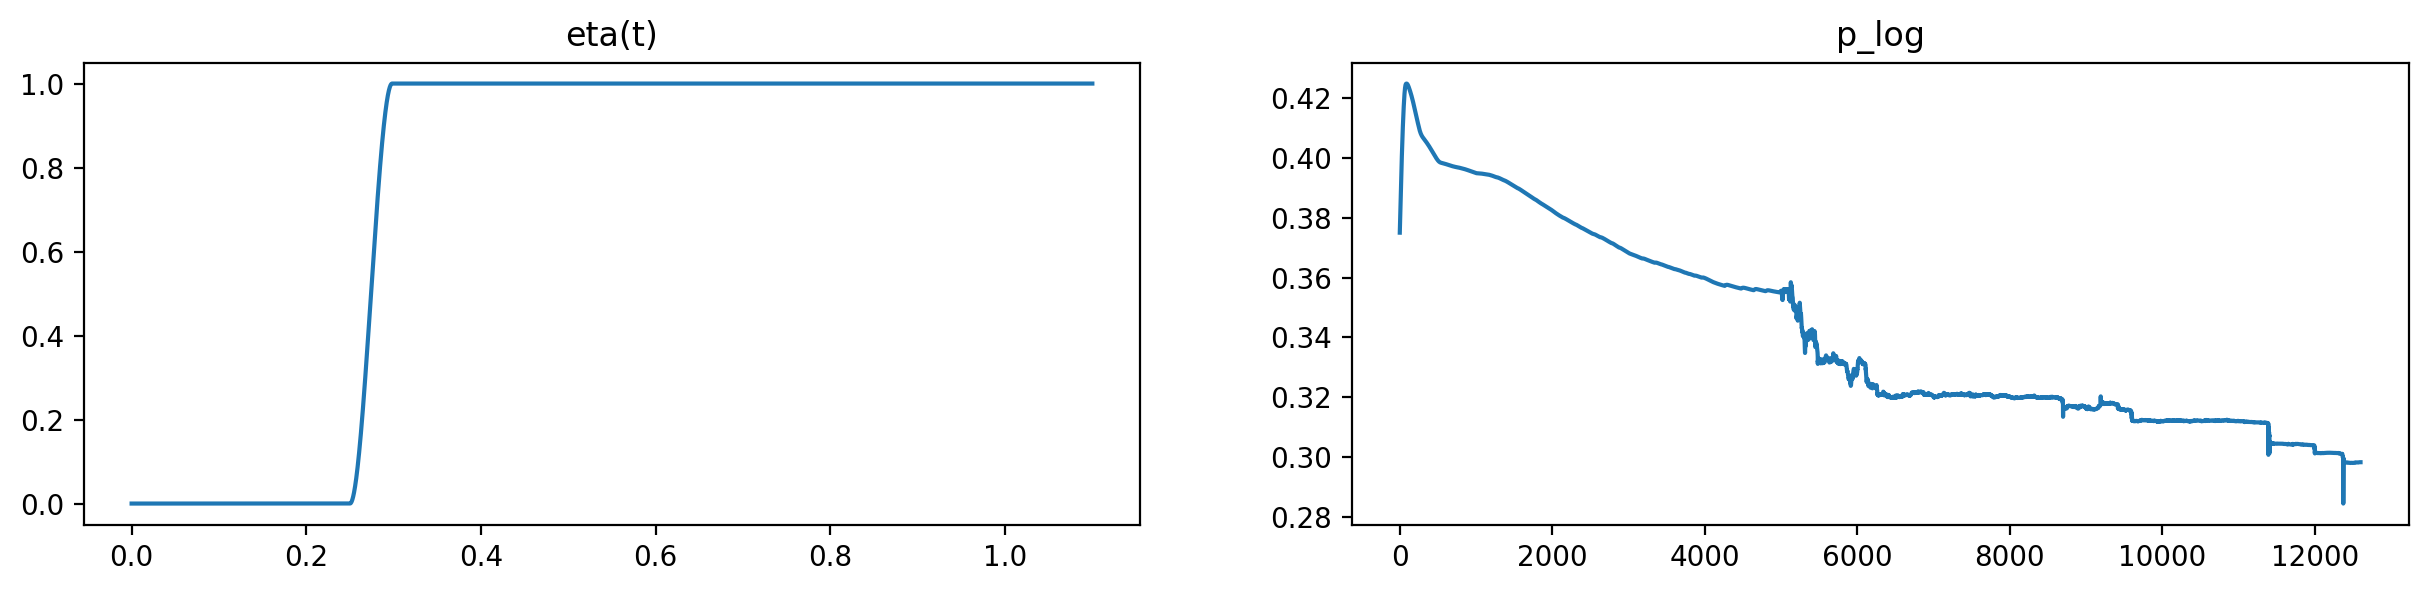

区间[0.25,0.50]的训练时间：9.05 min(s)
Final loss: 1.32699e-04,Total iteration: 12600

查看区间：[0.25,0.50]

Relative L2 error_u: 2.16713e-03

Relative L1 error_u: 1.11907e-03

Relative Linf error_u: 5.38427e-03
训练区间：[0.50,0.75]
p的初始化6.250e-01 

	====Begin Adam====
1000,loss:2.03088e-01,i:0.00e+00,f:2.02e-01,b:6.64e-04,p:7.41e-01
2000,loss:1.57921e-01,i:0.00e+00,f:1.56e-01,b:1.87e-03,p:7.30e-01
3000,loss:1.21708e-01,i:0.00e+00,f:1.19e-01,b:2.96e-03,p:7.23e-01
4000,loss:1.04489e-01,i:0.00e+00,f:1.01e-01,b:3.79e-03,p:7.22e-01
5000,loss:7.23770e-02,i:0.00e+00,f:7.00e-02,b:2.37e-03,p:7.15e-01

	====Begin LBFSG====
6000,loss:4.19915e-03,i:0.00e+00,f:3.88e-03,b:3.19e-04,p:6.16e-01
7000,loss:1.89043e-03,i:0.00e+00,f:1.75e-03,b:1.43e-04,p:6.00e-01
8000,loss:1.40941e-03,i:0.00e+00,f:1.34e-03,b:6.78e-05,p:5.96e-01
9000,loss:1.06470e-03,i:0.00e+00,f:1.01e-03,b:5.27e-05,p:5.84e-01
10000,loss:8.10236e-04,i:0.00e+00,f:7.85e-04,b:2.56e-05,p:5.76e-01
11000,loss:4.11082e-04,i:0.00e+00,f:3.85e-04,b:2.56e-05,p:5.66e

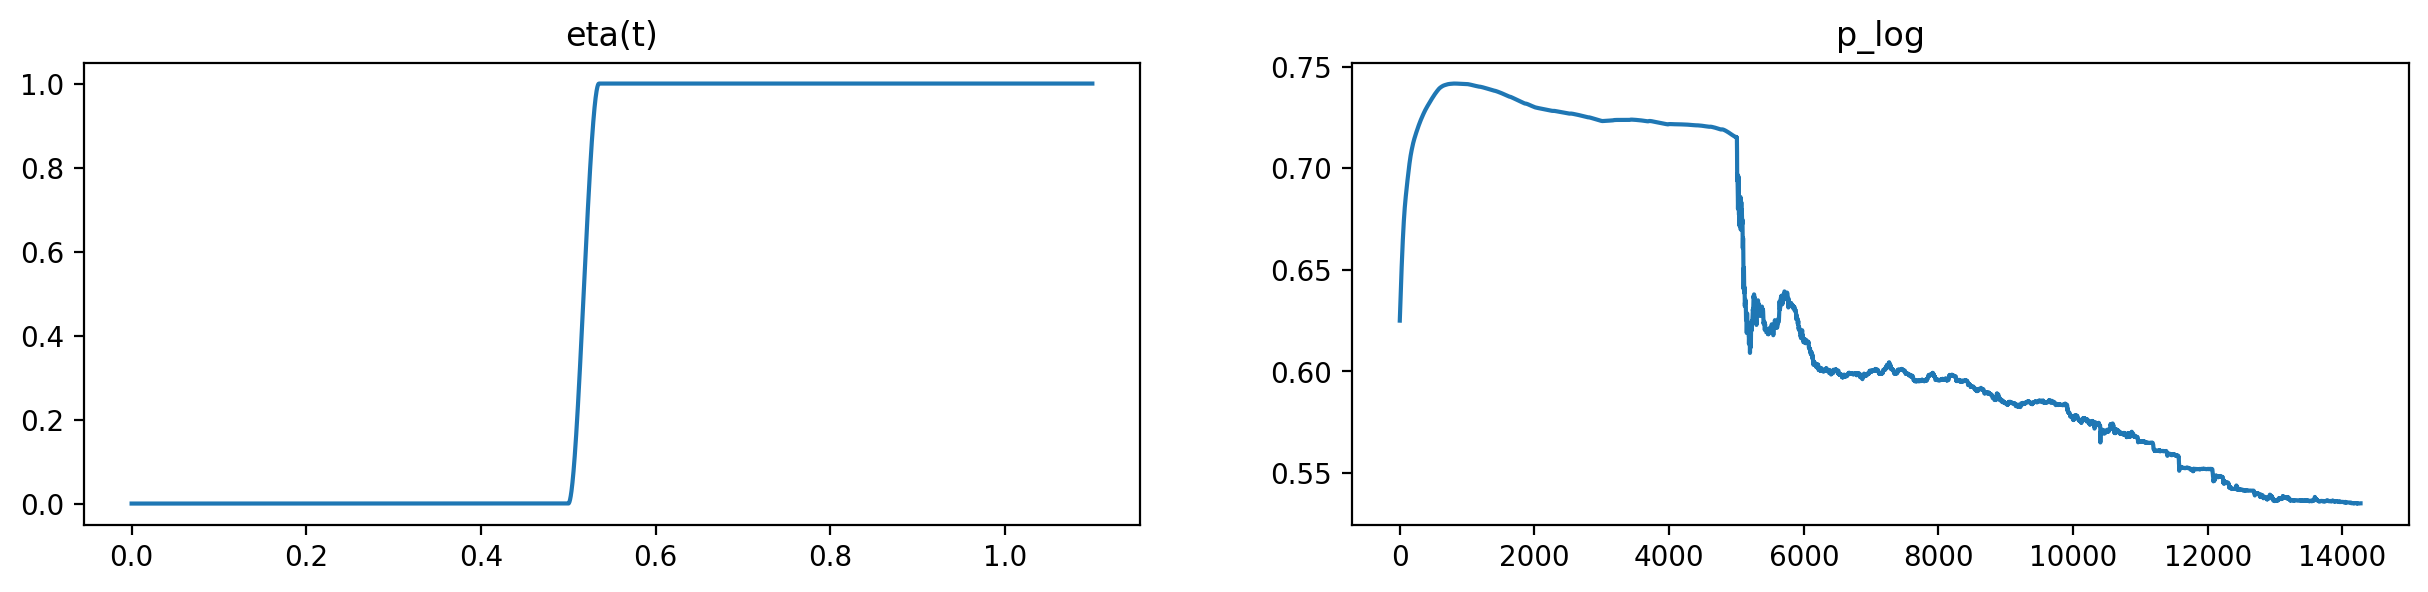

区间[0.50,0.75]的训练时间：10.68 min(s)
Final loss: 1.45064e-04,Total iteration: 14270

查看区间：[0.50,0.75]

Relative L2 error_u: 2.68595e-03

Relative L1 error_u: 1.49489e-03

Relative Linf error_u: 5.59965e-03
训练区间：[0.75,1.00]
p的初始化8.750e-01 

	====Begin Adam====
1000,loss:8.61026e-02,i:0.00e+00,f:7.92e-02,b:6.86e-03,p:1.00e+00
2000,loss:5.48799e-02,i:0.00e+00,f:4.77e-02,b:7.17e-03,p:1.00e+00
3000,loss:3.90343e-02,i:0.00e+00,f:3.35e-02,b:5.49e-03,p:1.00e+00
4000,loss:2.73830e-02,i:0.00e+00,f:2.27e-02,b:4.68e-03,p:1.00e+00
5000,loss:2.48218e-02,i:0.00e+00,f:2.08e-02,b:4.03e-03,p:1.00e+00

	====Begin LBFSG====
6000,loss:2.81725e-03,i:0.00e+00,f:2.54e-03,b:2.77e-04,p:1.00e+00
7000,loss:1.13455e-03,i:0.00e+00,f:9.74e-04,b:1.61e-04,p:1.00e+00
8000,loss:6.29736e-04,i:0.00e+00,f:5.00e-04,b:1.30e-04,p:1.00e+00
9000,loss:3.76659e-04,i:0.00e+00,f:3.16e-04,b:6.04e-05,p:1.00e+00
10000,loss:2.79820e-04,i:0.00e+00,f:2.38e-04,b:4.20e-05,p:1.00e+00
11000,loss:2.31084e-04,i:0.00e+00,f:1.93e-04,b:3.79e-05,p:1.00

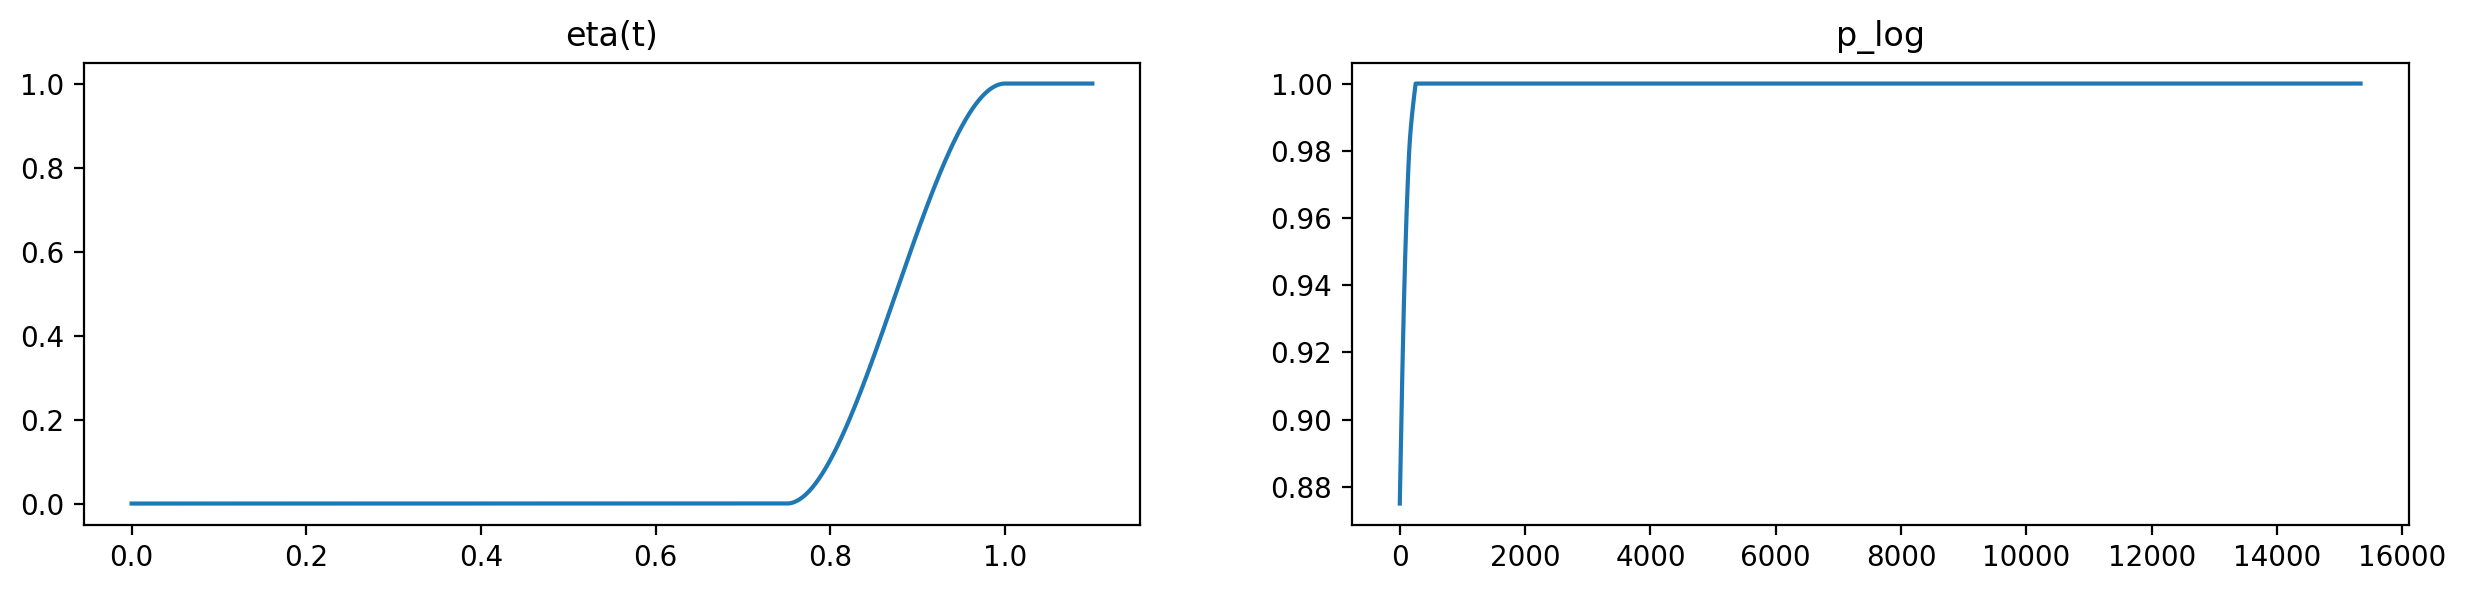

区间[0.75,1.00]的训练时间：11.76 min(s)
Final loss: 1.35518e-04,Total iteration: 15335

查看区间：[0.75,1.00]

Relative L2 error_u: 4.34297e-03

Relative L1 error_u: 2.53301e-03

Relative Linf error_u: 1.26880e-02

#小区间个数：4，总训练时长:37.29  min(s)

#查看区间[0.00,1.00]:
#error L2:2.91166e-03
#error L1:1.50625e-03
#error Linf:1.26880e-02
-----**区间个数：4, 第3次训练, 随机种子: 2154**-----
训练区间：[0.00,0.25]

	====Begin Adam====
1000,loss:2.23209e-02,i:8.00e-03,f:1.04e-02,b:3.90e-03
2000,loss:8.91795e-03,i:3.86e-03,f:4.26e-03,b:7.99e-04
3000,loss:4.20252e-03,i:2.19e-03,f:1.94e-03,b:7.61e-05
4000,loss:2.99895e-03,i:1.50e-03,f:1.44e-03,b:6.56e-05
5000,loss:2.37090e-03,i:1.23e-03,f:1.09e-03,b:5.08e-05

	====Begin LBFSG====
6000,loss:1.06581e-04,i:2.50e-05,f:7.93e-05,b:2.25e-06
7000,loss:3.24450e-05,i:1.00e-05,f:2.07e-05,b:1.68e-06
8000,loss:1.43609e-05,i:4.23e-06,f:9.44e-06,b:6.84e-07
9000,loss:8.63478e-06,i:2.17e-06,f:6.10e-06,b:3.64e-07
10000,loss:5.44380e-06,i:1.37e-06,f:3.89e-06,b:1.80e-07
11000,loss:3.69929e-06,i:8.22e-

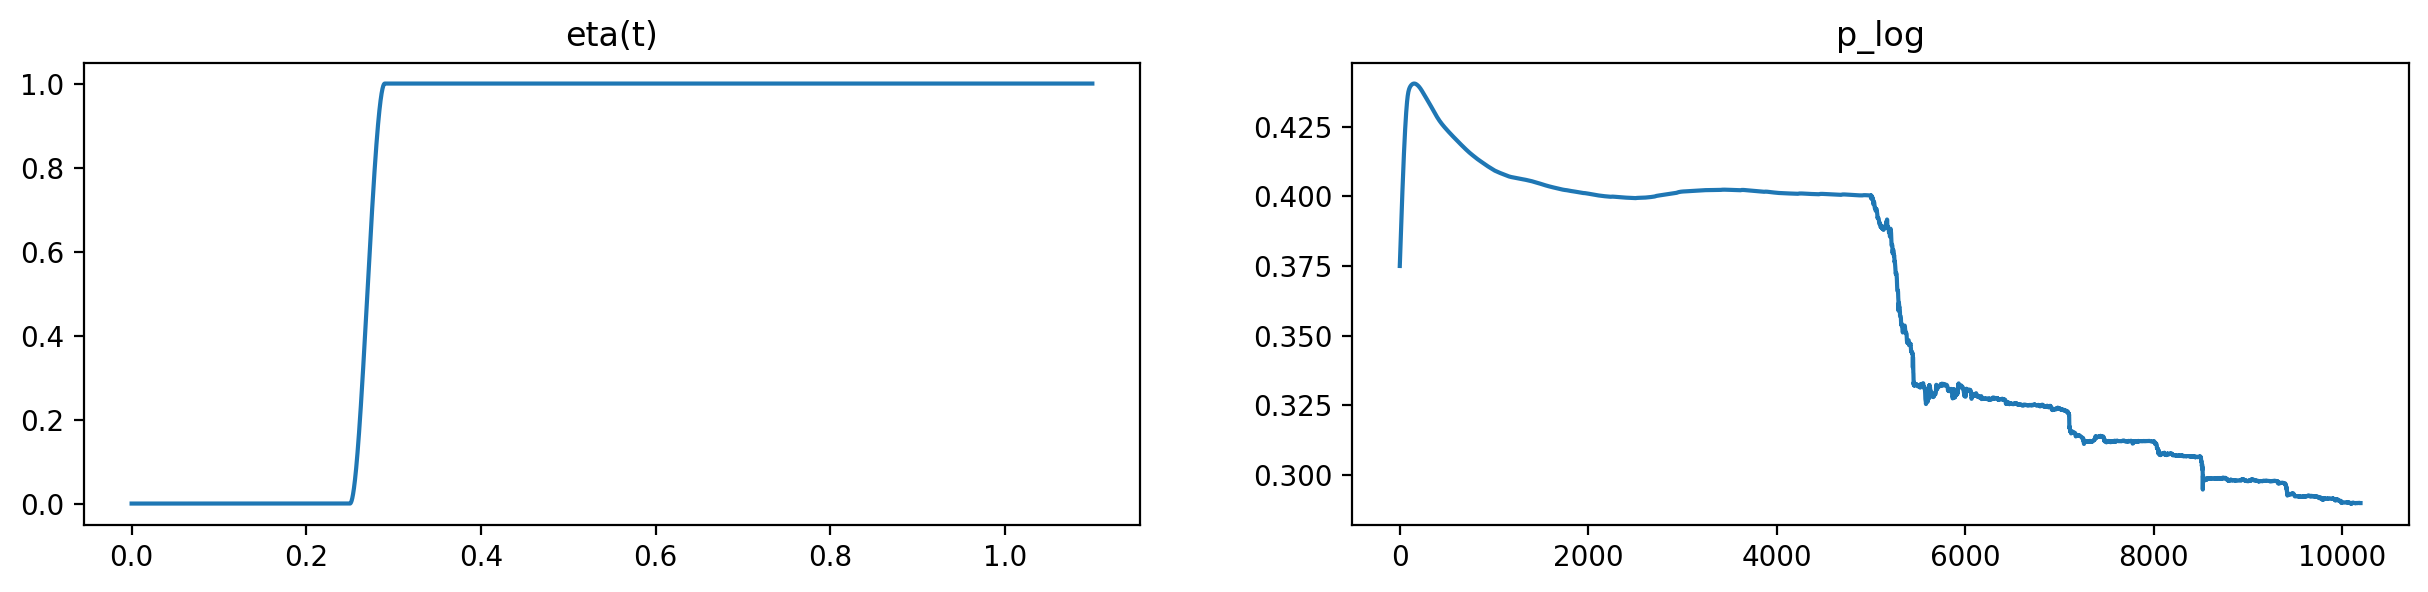

区间[0.25,0.50]的训练时间：6.79 min(s)
Final loss: 1.65718e-04,Total iteration: 10197

查看区间：[0.25,0.50]

Relative L2 error_u: 2.30897e-03

Relative L1 error_u: 1.16042e-03

Relative Linf error_u: 7.30744e-03
训练区间：[0.50,0.75]
p的初始化6.250e-01 

	====Begin Adam====
1000,loss:2.60942e-01,i:0.00e+00,f:2.60e-01,b:9.29e-04,p:7.46e-01
2000,loss:9.74851e-02,i:0.00e+00,f:9.55e-02,b:1.94e-03,p:7.42e-01
3000,loss:6.90128e-02,i:0.00e+00,f:6.80e-02,b:9.78e-04,p:7.22e-01
4000,loss:4.93275e-02,i:0.00e+00,f:4.79e-02,b:1.46e-03,p:6.97e-01
5000,loss:4.17400e-02,i:0.00e+00,f:4.08e-02,b:9.00e-04,p:6.83e-01

	====Begin LBFSG====
6000,loss:6.30731e-03,i:0.00e+00,f:6.16e-03,b:1.51e-04,p:6.00e-01
7000,loss:2.63772e-03,i:0.00e+00,f:2.53e-03,b:1.08e-04,p:5.79e-01
8000,loss:1.71406e-03,i:0.00e+00,f:1.65e-03,b:6.33e-05,p:5.69e-01
9000,loss:1.44156e-03,i:0.00e+00,f:1.37e-03,b:6.66e-05,p:5.69e-01
10000,loss:1.18340e-03,i:0.00e+00,f:1.14e-03,b:4.64e-05,p:5.68e-01
11000,loss:7.93596e-04,i:0.00e+00,f:7.74e-04,b:1.94e-05,p:5.41e

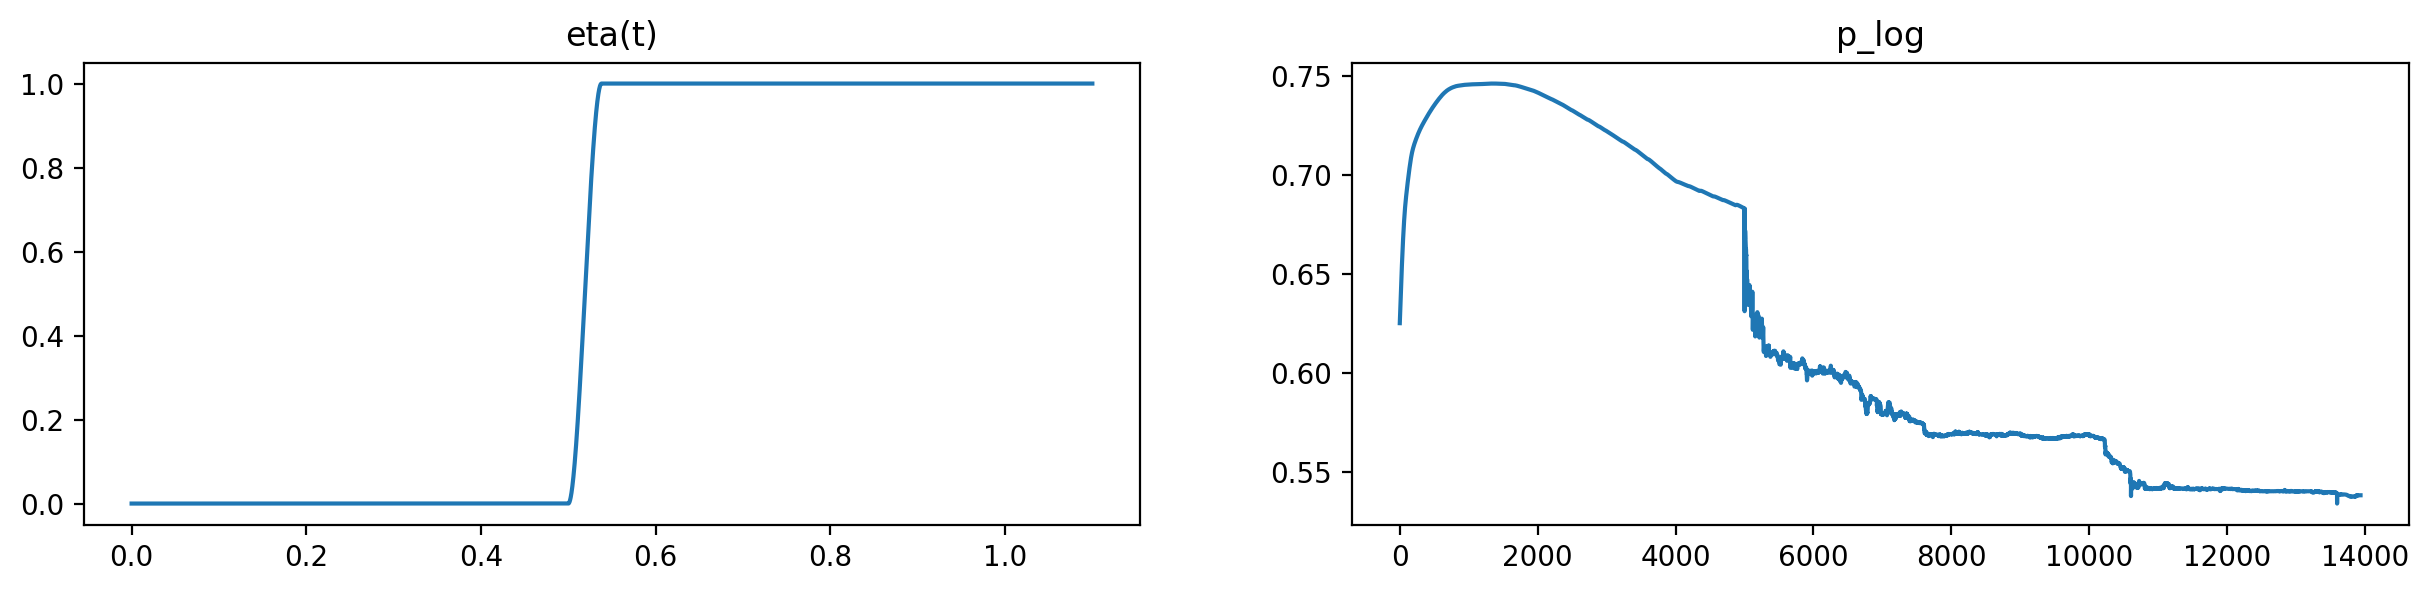

区间[0.50,0.75]的训练时间：10.44 min(s)
Final loss: 3.84797e-04,Total iteration: 13935

查看区间：[0.50,0.75]

Relative L2 error_u: 3.41314e-03

Relative L1 error_u: 1.77263e-03

Relative Linf error_u: 1.05610e-02
训练区间：[0.75,1.00]
p的初始化8.750e-01 

	====Begin Adam====
1000,loss:1.72322e-01,i:0.00e+00,f:1.58e-01,b:1.41e-02,p:1.00e+00
2000,loss:5.41809e-02,i:0.00e+00,f:3.97e-02,b:1.45e-02,p:1.00e+00
3000,loss:5.22234e-02,i:0.00e+00,f:4.00e-02,b:1.22e-02,p:1.00e+00
4000,loss:3.28639e-02,i:0.00e+00,f:2.15e-02,b:1.14e-02,p:1.00e+00
5000,loss:2.97517e-02,i:0.00e+00,f:1.90e-02,b:1.08e-02,p:1.00e+00

	====Begin LBFSG====
6000,loss:5.76494e-03,i:0.00e+00,f:4.38e-03,b:1.38e-03,p:1.00e+00
7000,loss:2.78414e-03,i:0.00e+00,f:2.23e-03,b:5.51e-04,p:1.00e+00
8000,loss:1.33997e-03,i:0.00e+00,f:1.15e-03,b:1.91e-04,p:1.00e+00
9000,loss:9.31559e-04,i:0.00e+00,f:7.73e-04,b:1.58e-04,p:1.00e+00
10000,loss:7.69202e-04,i:0.00e+00,f:6.10e-04,b:1.59e-04,p:1.00e+00
11000,loss:6.71568e-04,i:0.00e+00,f:5.24e-04,b:1.47e-04,p:1.00

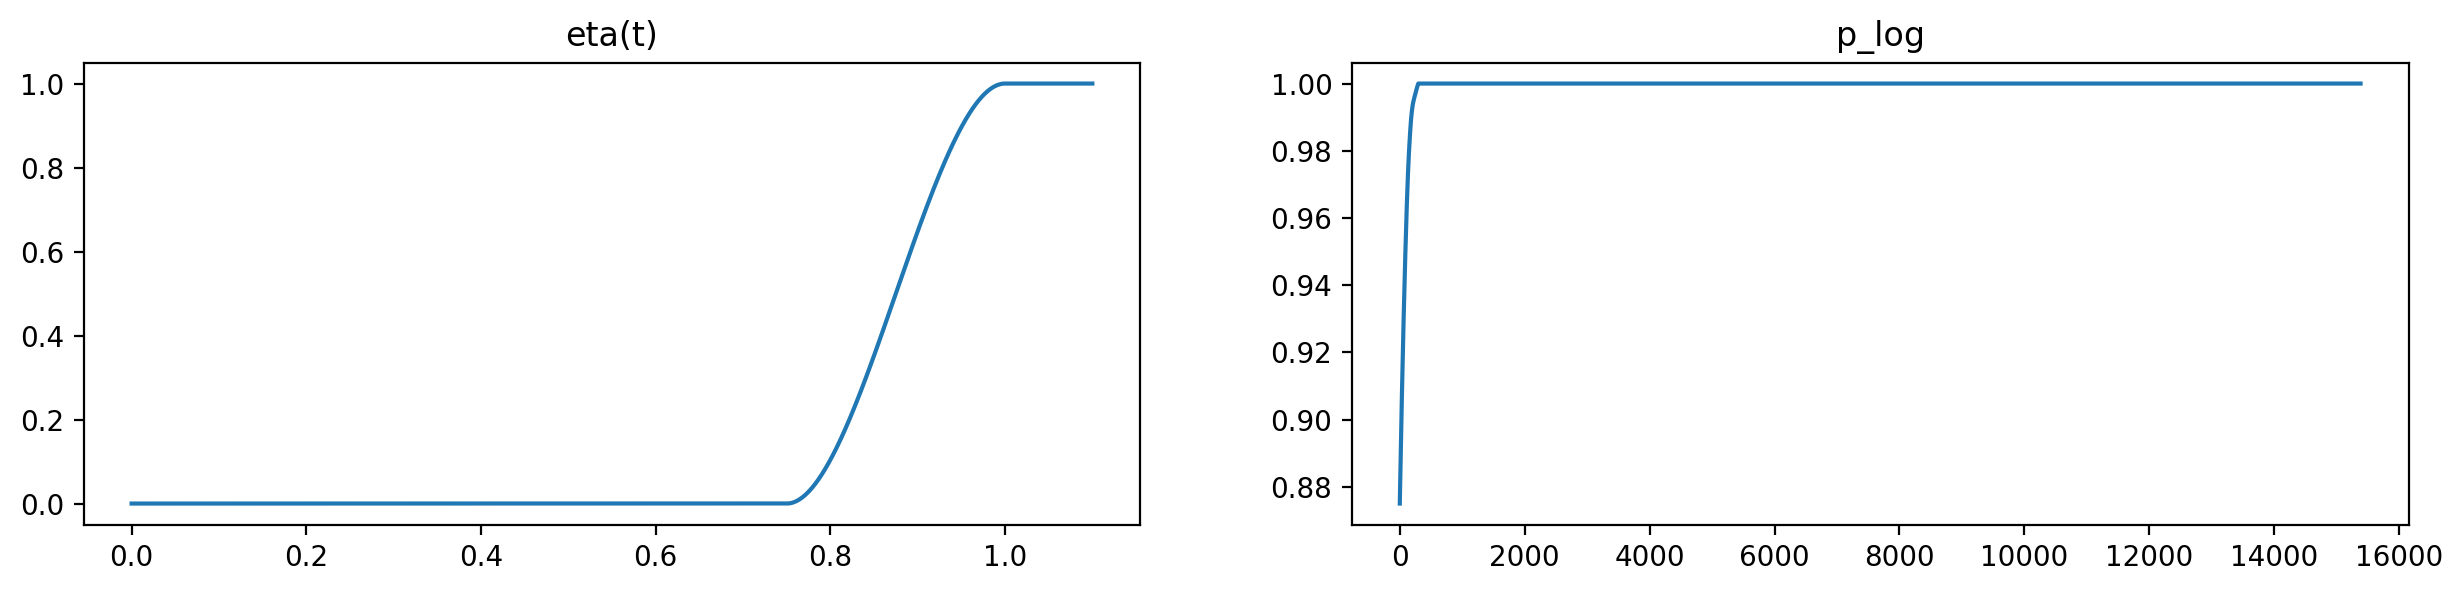

区间[0.75,1.00]的训练时间：11.82 min(s)
Final loss: 4.01080e-04,Total iteration: 15382

查看区间：[0.75,1.00]

Relative L2 error_u: 9.62898e-03

Relative L1 error_u: 4.61476e-03

Relative Linf error_u: 3.07266e-02

#小区间个数：4，总训练时长:34.71  min(s)

#查看区间[0.00,1.00]:
#error L2:5.30738e-03
#error L1:2.08477e-03
#error Linf:3.07266e-02
-----**区间个数：4, 第4次训练, 随机种子: 2789**-----
训练区间：[0.00,0.25]

	====Begin Adam====
1000,loss:1.45302e-02,i:7.16e-03,f:6.44e-03,b:9.27e-04
2000,loss:6.02555e-03,i:2.54e-03,f:3.33e-03,b:1.53e-04
3000,loss:3.94943e-03,i:1.75e-03,f:2.05e-03,b:1.55e-04
4000,loss:2.71513e-03,i:1.19e-03,f:1.28e-03,b:2.39e-04
5000,loss:1.78688e-03,i:7.83e-04,f:9.00e-04,b:1.04e-04

	====Begin LBFSG====
6000,loss:8.77864e-05,i:3.06e-05,f:5.15e-05,b:5.67e-06
7000,loss:4.07894e-05,i:1.39e-05,f:2.38e-05,b:3.12e-06
8000,loss:2.18248e-05,i:5.77e-06,f:1.44e-05,b:1.70e-06
9000,loss:1.46135e-05,i:3.12e-06,f:1.07e-05,b:8.44e-07
10000,loss:9.47342e-06,i:1.98e-06,f:7.21e-06,b:2.83e-07
11000,loss:6.59797e-06,i:1.44e-

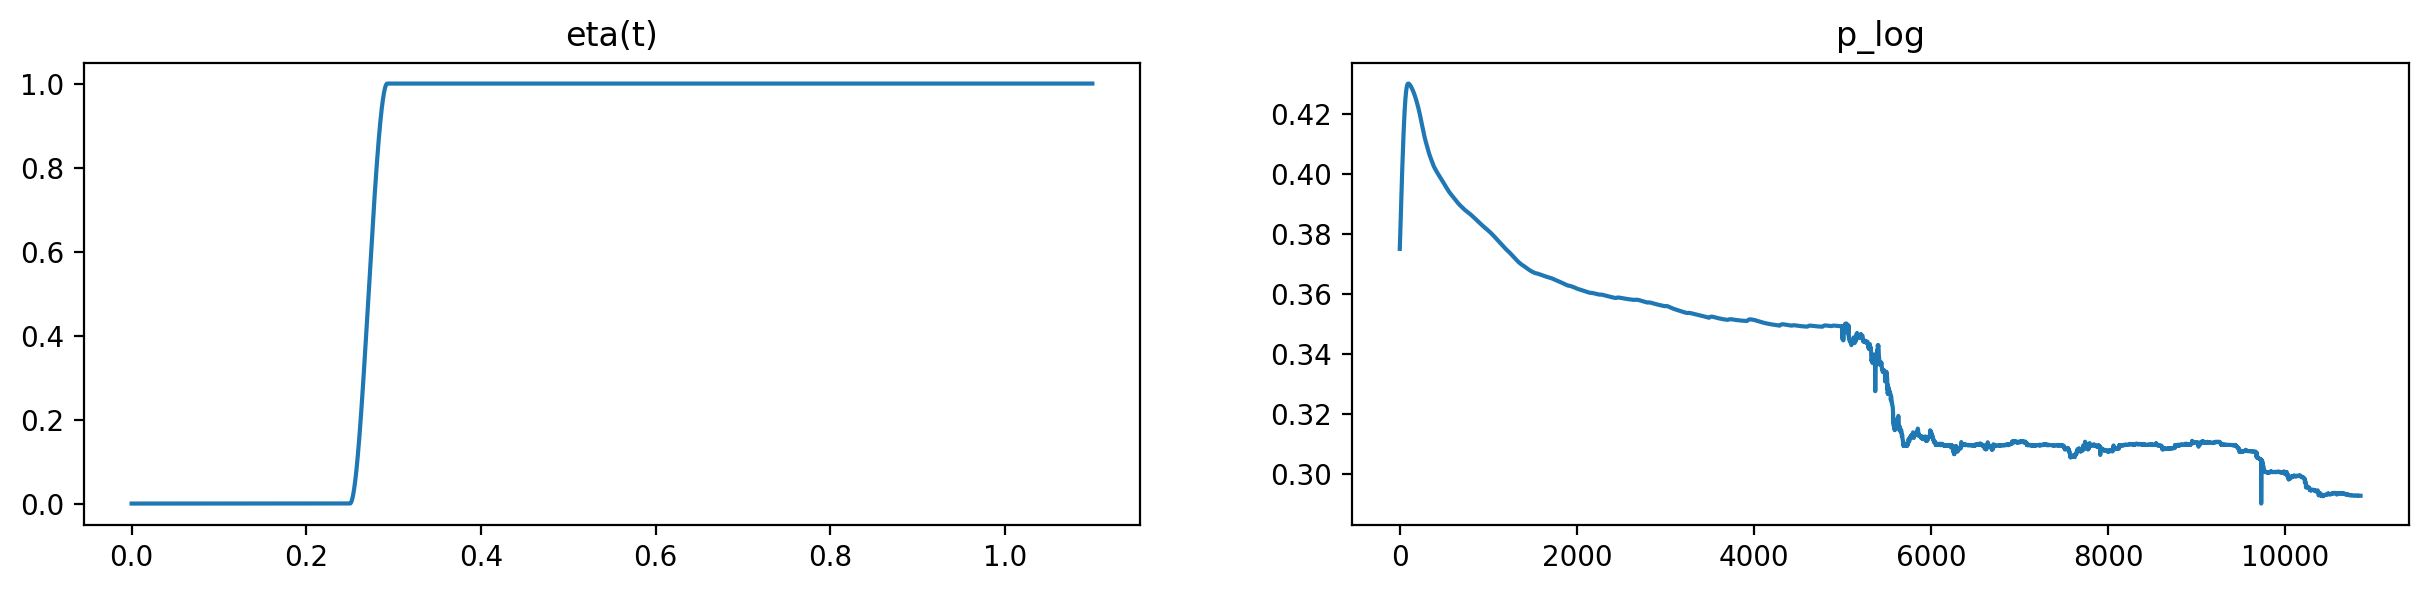

区间[0.25,0.50]的训练时间：7.47 min(s)
Final loss: 5.86121e-04,Total iteration: 10854

查看区间：[0.25,0.50]

Relative L2 error_u: 4.03706e-03

Relative L1 error_u: 2.08458e-03

Relative Linf error_u: 1.21447e-02
训练区间：[0.50,0.75]
p的初始化6.250e-01 

	====Begin Adam====
1000,loss:3.02005e-01,i:0.00e+00,f:3.01e-01,b:8.43e-04,p:7.50e-01
2000,loss:1.45307e-01,i:0.00e+00,f:1.41e-01,b:4.11e-03,p:7.50e-01
3000,loss:9.75830e-02,i:0.00e+00,f:9.20e-02,b:5.57e-03,p:7.50e-01
4000,loss:5.89861e-02,i:0.00e+00,f:5.67e-02,b:2.27e-03,p:7.50e-01
5000,loss:1.90606e-02,i:0.00e+00,f:1.87e-02,b:3.34e-04,p:7.50e-01

	====Begin LBFSG====
6000,loss:4.20449e-03,i:0.00e+00,f:4.14e-03,b:6.71e-05,p:7.50e-01
7000,loss:2.03328e-03,i:0.00e+00,f:1.97e-03,b:6.18e-05,p:7.50e-01
8000,loss:9.83131e-04,i:0.00e+00,f:9.44e-04,b:3.93e-05,p:7.50e-01
9000,loss:6.74155e-04,i:0.00e+00,f:6.38e-04,b:3.57e-05,p:7.50e-01
10000,loss:5.28491e-04,i:0.00e+00,f:5.08e-04,b:2.04e-05,p:7.50e-01
11000,loss:4.69789e-04,i:0.00e+00,f:4.53e-04,b:1.72e-05,p:7.50e

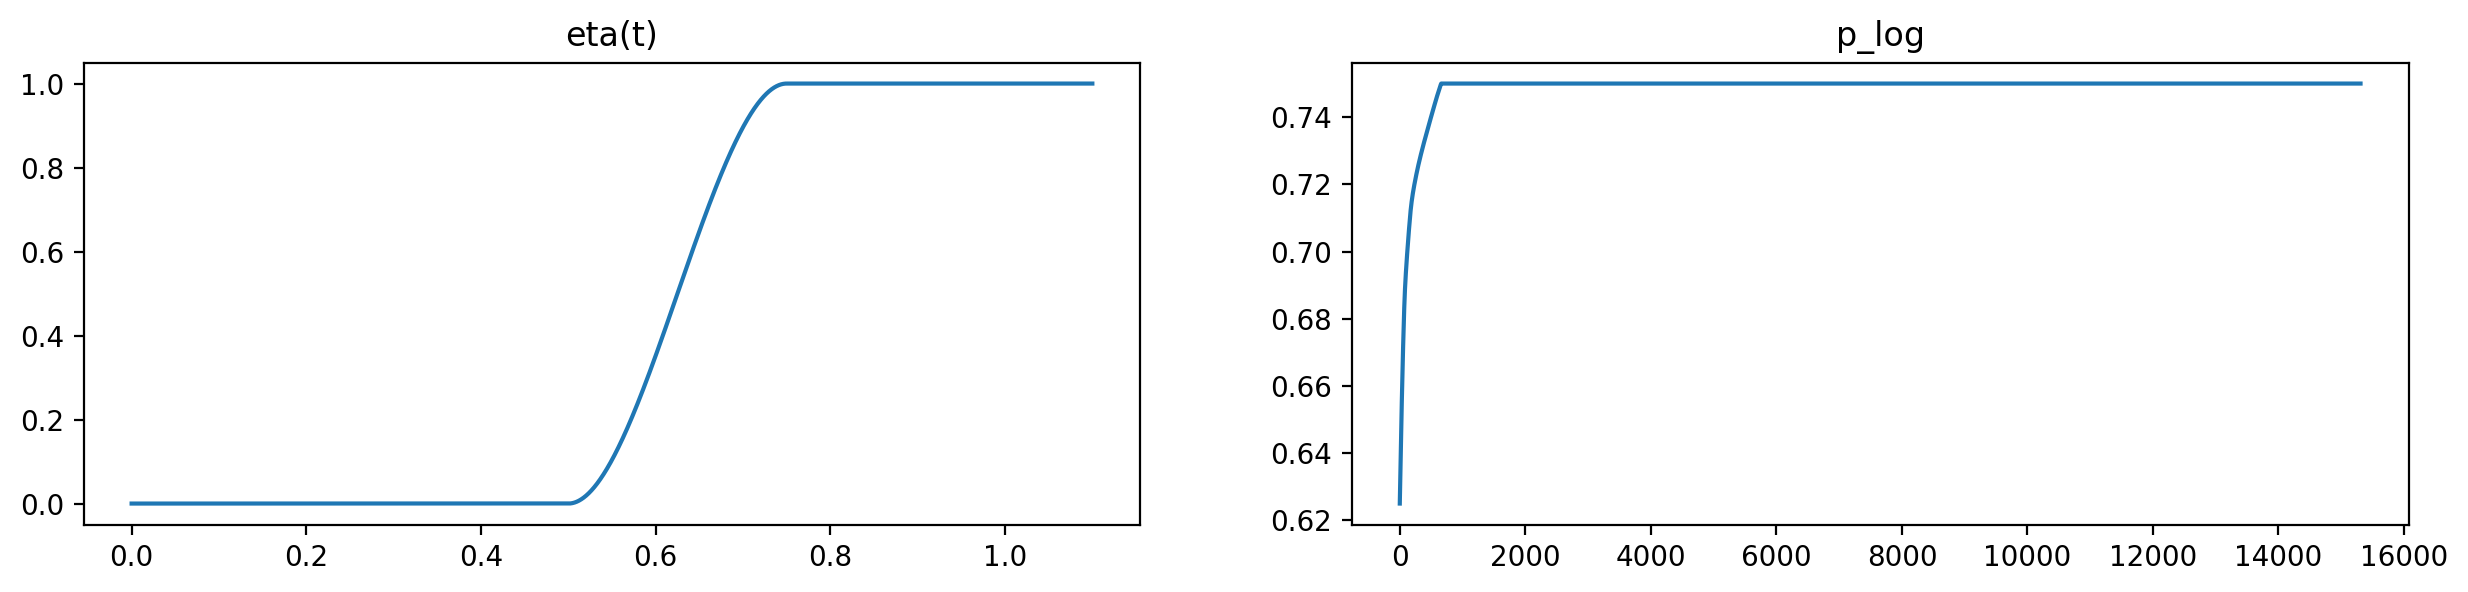

区间[0.50,0.75]的训练时间：11.72 min(s)
Final loss: 3.12459e-04,Total iteration: 15309

查看区间：[0.50,0.75]

Relative L2 error_u: 6.07147e-03

Relative L1 error_u: 2.97859e-03

Relative Linf error_u: 1.27289e-02
训练区间：[0.75,1.00]
p的初始化8.750e-01 

	====Begin Adam====
1000,loss:1.33063e-01,i:0.00e+00,f:1.12e-01,b:2.07e-02,p:9.84e-01
2000,loss:9.57603e-02,i:0.00e+00,f:7.32e-02,b:2.26e-02,p:9.93e-01
3000,loss:8.57982e-02,i:0.00e+00,f:6.44e-02,b:2.14e-02,p:1.00e+00
4000,loss:7.64398e-02,i:0.00e+00,f:5.61e-02,b:2.03e-02,p:1.00e+00
5000,loss:8.91603e-02,i:0.00e+00,f:7.16e-02,b:1.75e-02,p:1.00e+00

	====Begin LBFSG====
6000,loss:1.45440e-02,i:0.00e+00,f:1.41e-02,b:4.03e-04,p:1.00e+00
7000,loss:6.63925e-03,i:0.00e+00,f:6.45e-03,b:1.86e-04,p:1.00e+00
8000,loss:4.00597e-03,i:0.00e+00,f:3.84e-03,b:1.65e-04,p:1.00e+00
9000,loss:3.10546e-03,i:0.00e+00,f:2.91e-03,b:1.95e-04,p:1.00e+00
10000,loss:2.37393e-03,i:0.00e+00,f:2.25e-03,b:1.26e-04,p:1.00e+00
11000,loss:1.56441e-03,i:0.00e+00,f:1.47e-03,b:9.39e-05,p:1.00

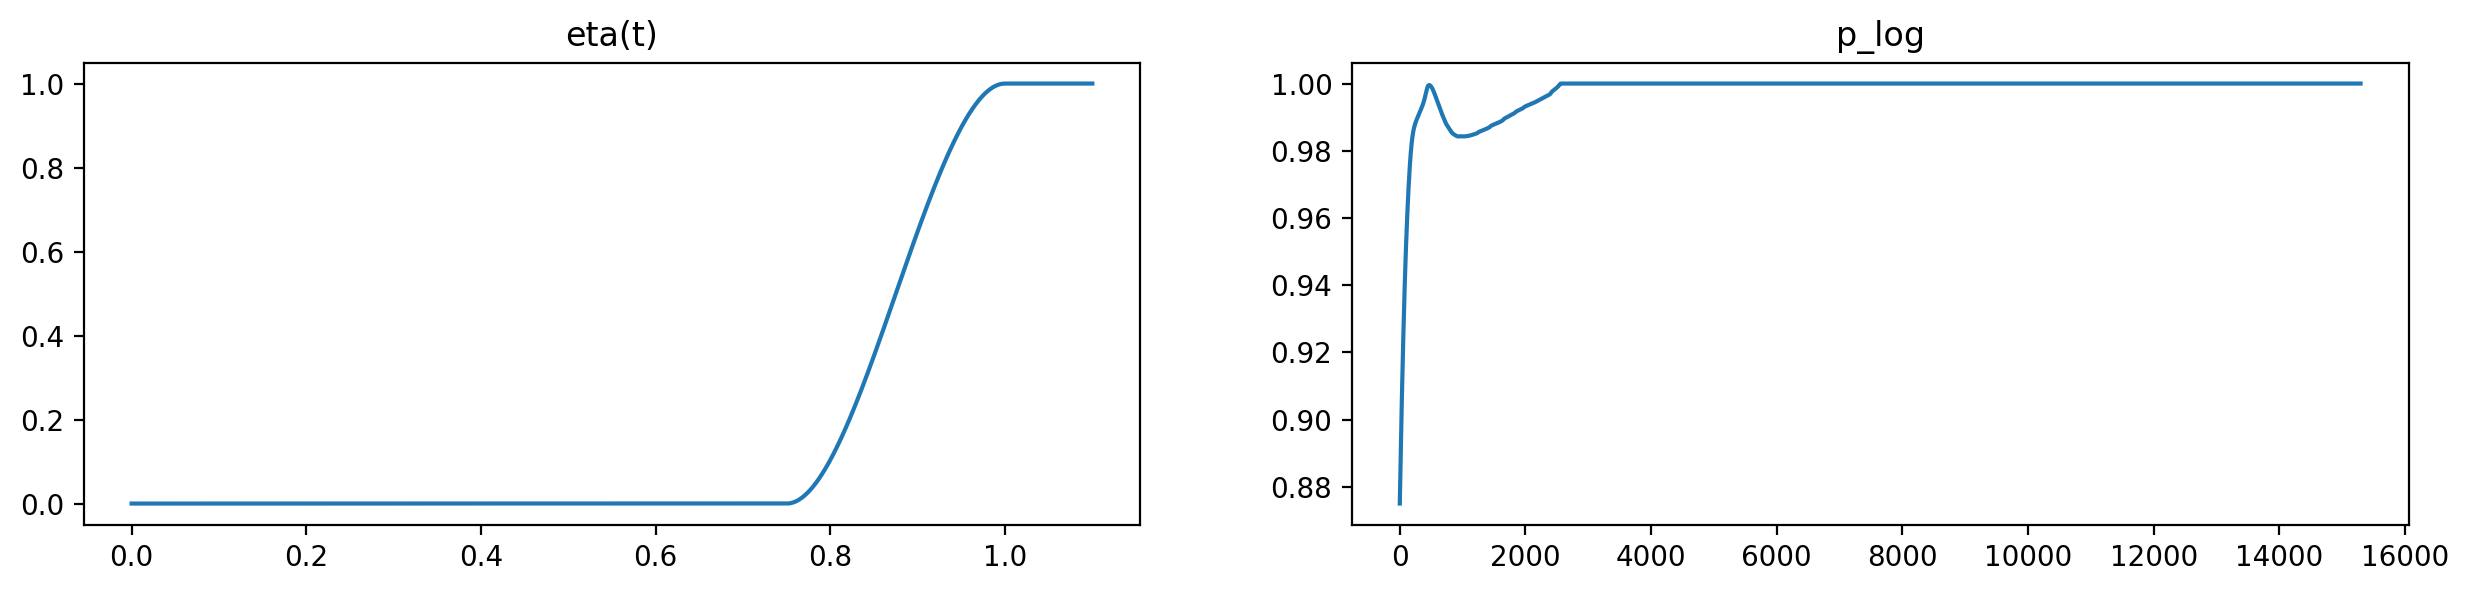

区间[0.75,1.00]的训练时间：11.88 min(s)
Final loss: 7.52380e-04,Total iteration: 15293

查看区间：[0.75,1.00]

Relative L2 error_u: 7.10341e-03

Relative L1 error_u: 3.64378e-03

Relative Linf error_u: 1.59433e-02

#小区间个数：4，总训练时长:37.07  min(s)

#查看区间[0.00,1.00]:
#error L2:5.17084e-03
#error L1:2.41046e-03
#error Linf:1.59433e-02
-----**区间个数：4, 第5次训练, 随机种子: 257**-----
训练区间：[0.00,0.25]

	====Begin Adam====
1000,loss:7.72812e-03,i:3.35e-03,f:3.64e-03,b:7.34e-04
2000,loss:2.48190e-03,i:9.72e-04,f:1.28e-03,b:2.35e-04
3000,loss:1.39152e-03,i:5.49e-04,f:7.26e-04,b:1.17e-04
4000,loss:9.16300e-04,i:3.50e-04,f:5.06e-04,b:6.04e-05
5000,loss:6.79503e-04,i:2.43e-04,f:4.00e-04,b:3.74e-05

	====Begin LBFSG====
6000,loss:6.53135e-05,i:2.31e-05,f:4.06e-05,b:1.60e-06
7000,loss:2.51814e-05,i:7.05e-06,f:1.61e-05,b:2.00e-06
8000,loss:1.23159e-05,i:3.13e-06,f:8.13e-06,b:1.05e-06
9000,loss:7.02477e-06,i:1.12e-06,f:5.51e-06,b:3.94e-07
10000,loss:4.57279e-06,i:8.69e-07,f:3.42e-06,b:2.88e-07
11000,loss:3.10132e-06,i:5.25e-0

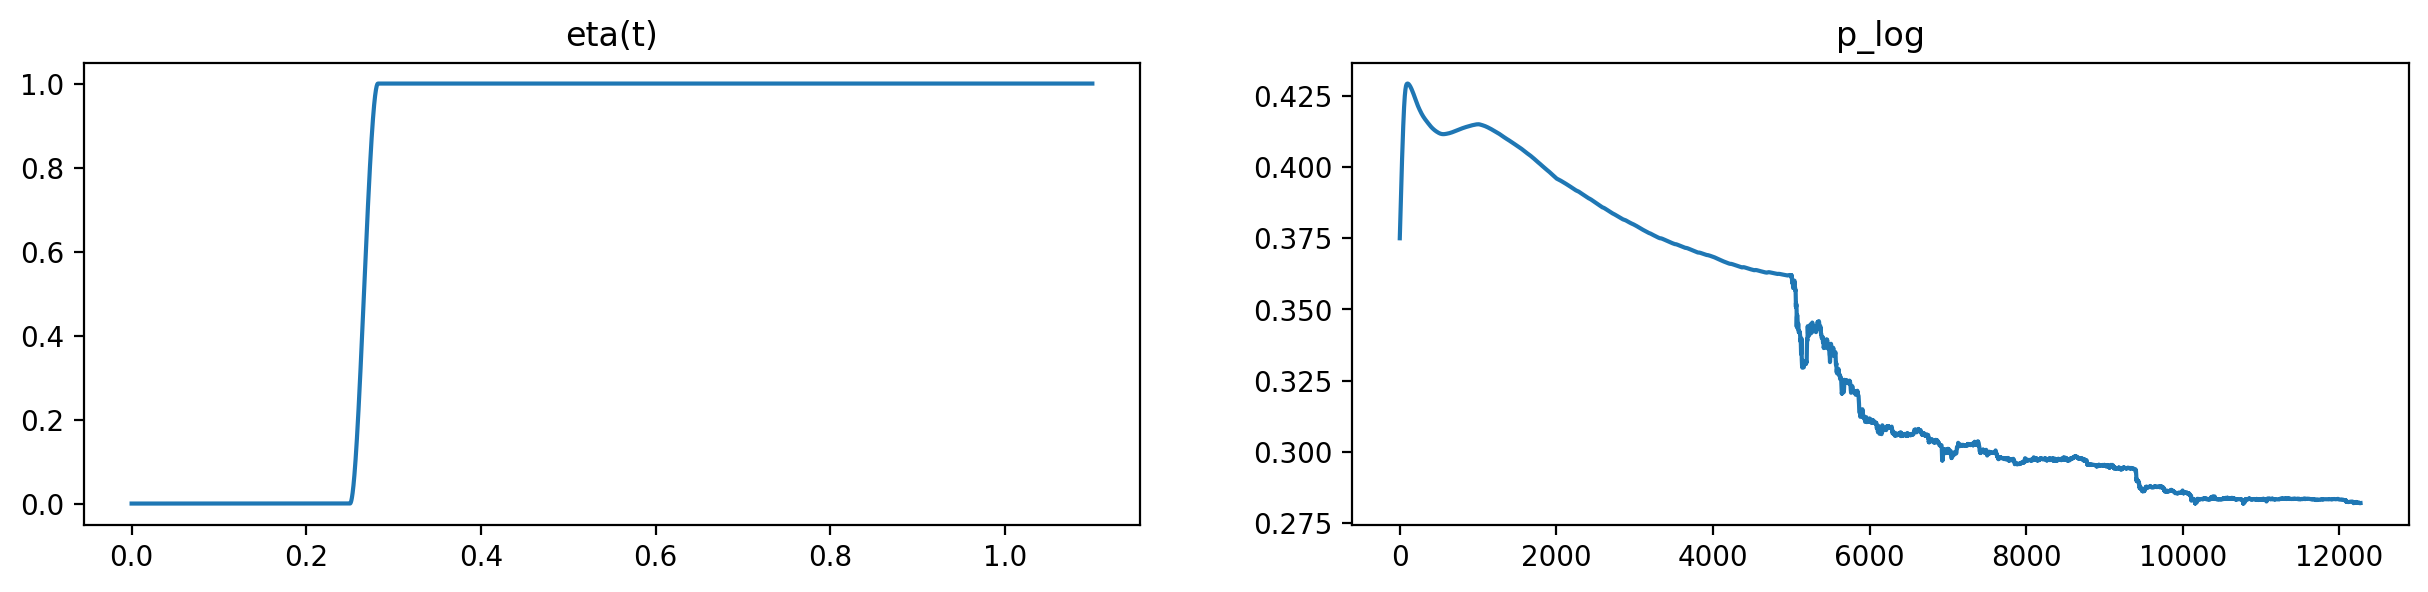

区间[0.25,0.50]的训练时间：15.20 min(s)
Final loss: 9.59771e-05,Total iteration: 12273

查看区间：[0.25,0.50]

Relative L2 error_u: 1.84518e-03

Relative L1 error_u: 9.60756e-04

Relative Linf error_u: 5.87562e-03
训练区间：[0.50,0.75]
p的初始化6.250e-01 

	====Begin Adam====
1000,loss:3.31895e-01,i:0.00e+00,f:3.31e-01,b:4.89e-04,p:7.50e-01
2000,loss:1.75579e-01,i:0.00e+00,f:1.73e-01,b:2.77e-03,p:7.50e-01
3000,loss:1.25952e-01,i:0.00e+00,f:1.22e-01,b:3.48e-03,p:7.50e-01
4000,loss:9.52417e-02,i:0.00e+00,f:9.45e-02,b:7.67e-04,p:7.50e-01
5000,loss:8.36639e-02,i:0.00e+00,f:8.33e-02,b:3.25e-04,p:7.50e-01

	====Begin LBFSG====
6000,loss:9.44708e-03,i:0.00e+00,f:9.27e-03,b:1.80e-04,p:7.50e-01
7000,loss:3.59946e-03,i:0.00e+00,f:3.20e-03,b:3.95e-04,p:7.50e-01
8000,loss:1.63332e-03,i:0.00e+00,f:1.51e-03,b:1.25e-04,p:7.50e-01
9000,loss:9.83222e-04,i:0.00e+00,f:9.54e-04,b:2.89e-05,p:7.50e-01
10000,loss:7.70720e-04,i:0.00e+00,f:7.49e-04,b:2.20e-05,p:7.50e-01
11000,loss:6.28872e-04,i:0.00e+00,f:6.12e-04,b:1.70e-05,p:7.50

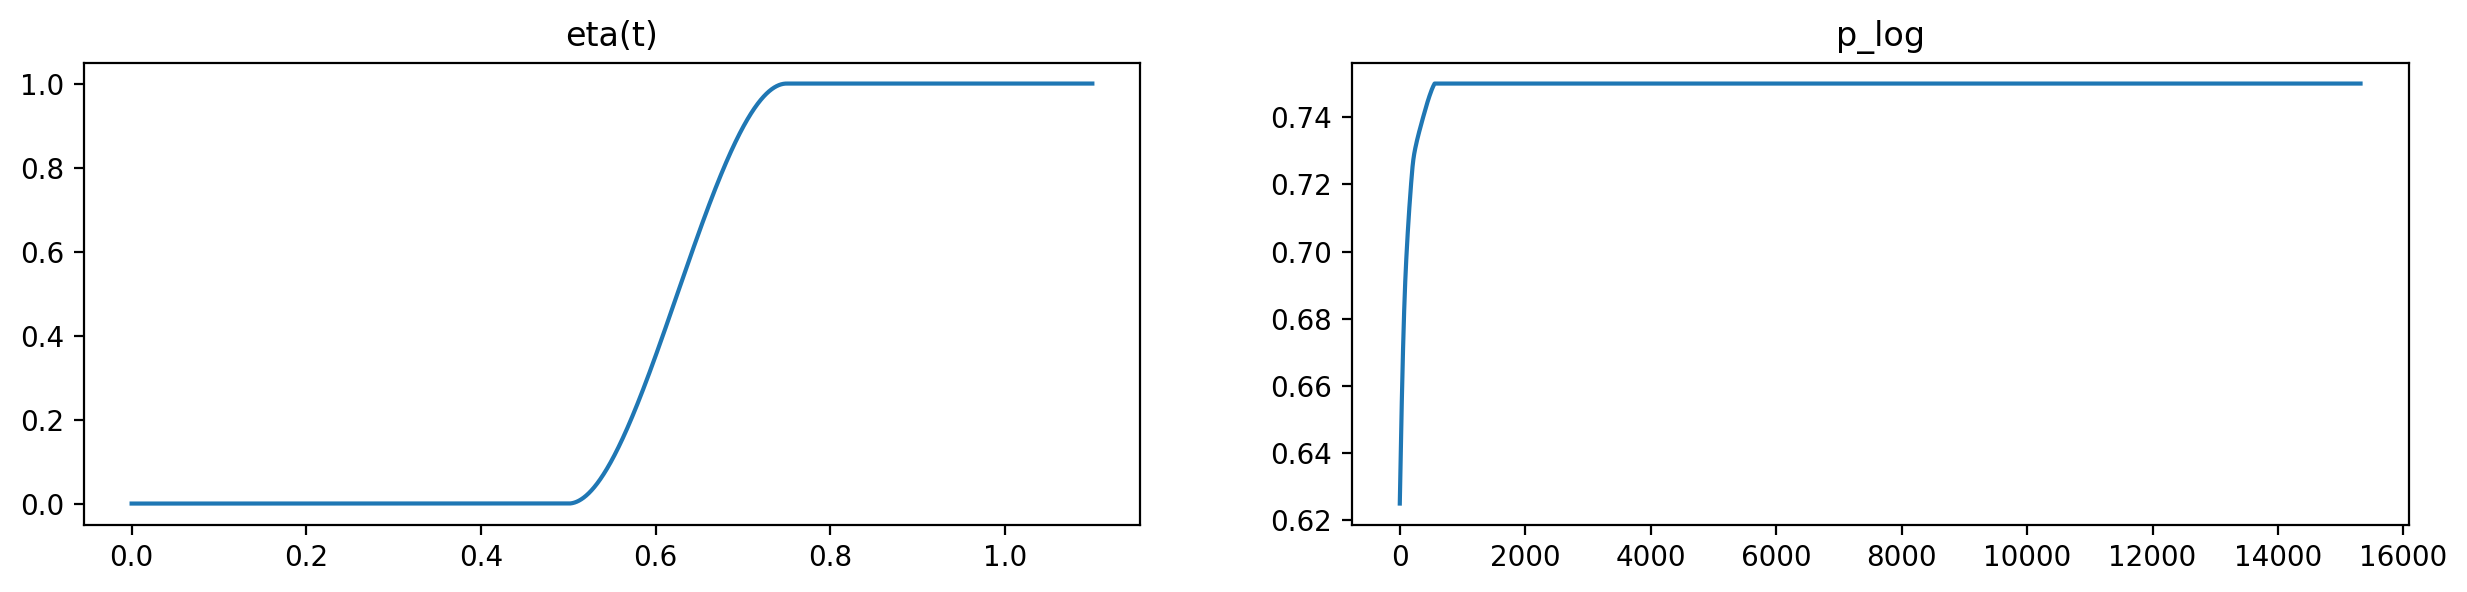

区间[0.50,0.75]的训练时间：11.43 min(s)
Final loss: 2.39103e-04,Total iteration: 15317

查看区间：[0.50,0.75]

Relative L2 error_u: 2.72705e-03

Relative L1 error_u: 1.37769e-03

Relative Linf error_u: 1.35224e-02
训练区间：[0.75,1.00]
p的初始化8.750e-01 

	====Begin Adam====
1000,loss:5.29316e-01,i:0.00e+00,f:5.09e-01,b:2.01e-02,p:9.96e-01
2000,loss:2.06944e-01,i:0.00e+00,f:1.91e-01,b:1.57e-02,p:9.94e-01
3000,loss:1.35000e-01,i:0.00e+00,f:1.17e-01,b:1.78e-02,p:9.82e-01
4000,loss:9.37357e-02,i:0.00e+00,f:8.03e-02,b:1.34e-02,p:9.39e-01
5000,loss:6.88436e-02,i:0.00e+00,f:6.14e-02,b:7.46e-03,p:8.95e-01

	====Begin LBFSG====
6000,loss:1.58053e-02,i:0.00e+00,f:1.28e-02,b:2.99e-03,p:8.32e-01
7000,loss:9.69082e-03,i:0.00e+00,f:8.15e-03,b:1.55e-03,p:8.24e-01
8000,loss:6.97098e-03,i:0.00e+00,f:5.96e-03,b:1.01e-03,p:8.22e-01
9000,loss:5.17438e-03,i:0.00e+00,f:4.42e-03,b:7.54e-04,p:8.08e-01
10000,loss:3.23375e-03,i:0.00e+00,f:2.84e-03,b:3.96e-04,p:7.95e-01
11000,loss:1.87770e-03,i:0.00e+00,f:1.61e-03,b:2.66e-04,p:7.88

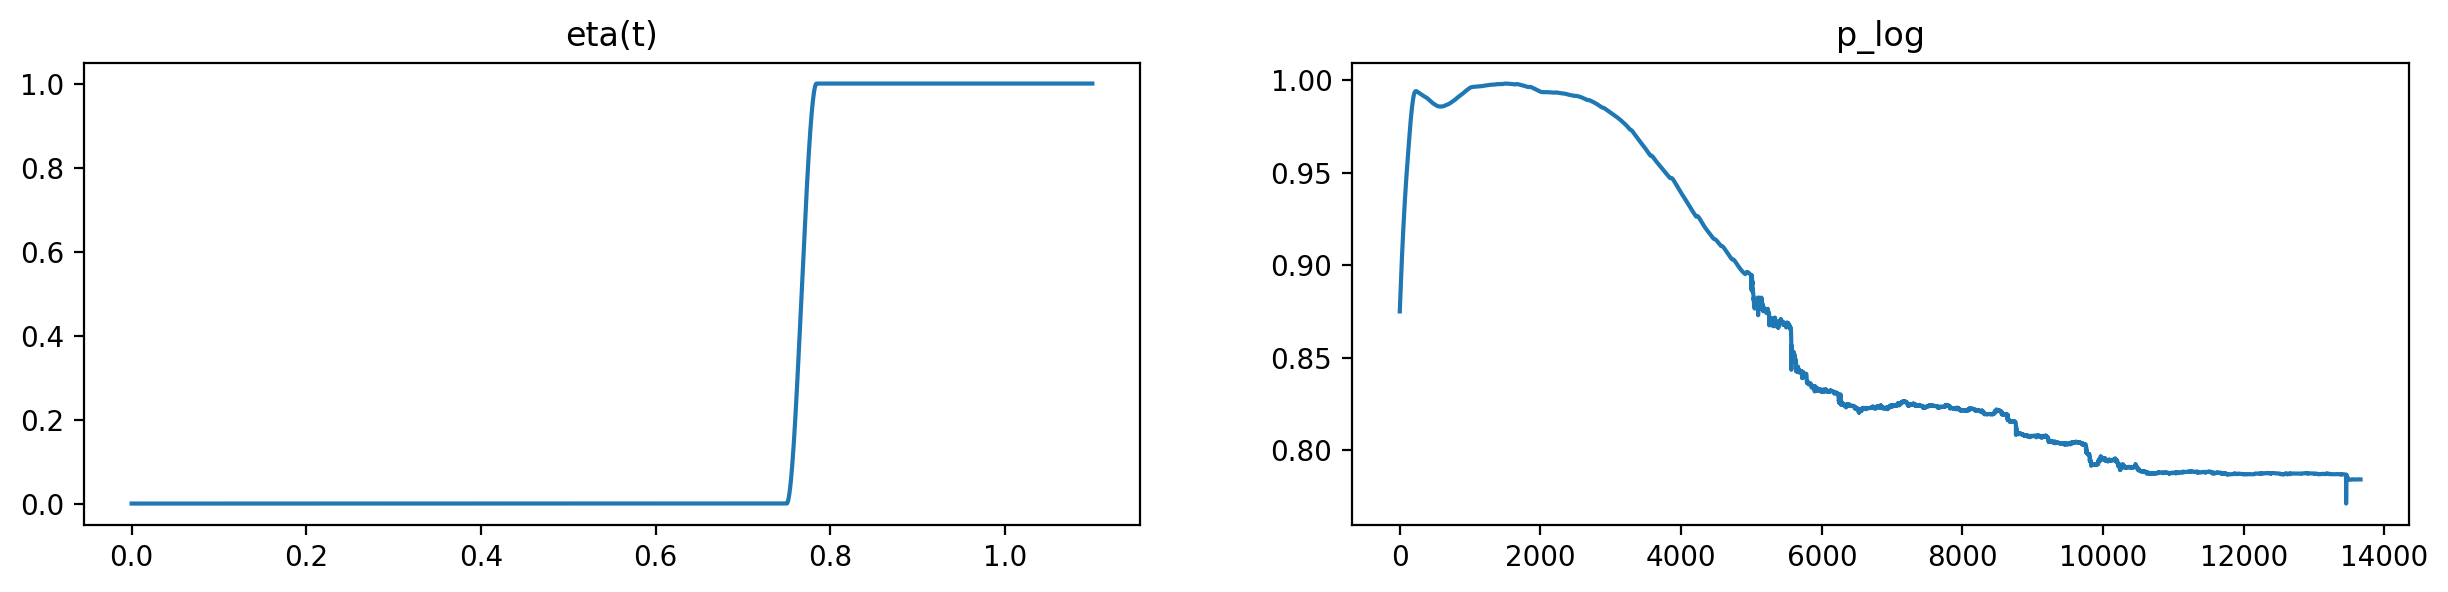

区间[0.75,1.00]的训练时间：9.78 min(s)
Final loss: 1.04818e-03,Total iteration: 13661

查看区间：[0.75,1.00]

Relative L2 error_u: 1.58999e-02

Relative L1 error_u: 5.98180e-03

Relative Linf error_u: 4.77340e-02

#小区间个数：4，总训练时长:42.15  min(s)

#查看区间[0.00,1.00]:
#error L2:8.19017e-03
#error L1:2.27290e-03
#error Linf:4.77340e-02


In [16]:



# %%



with pd.ExcelWriter(folder_path + '/error.xlsx', engine='openpyxl') as writer:
    for num in range(num_block_start, num_block_end + 1):  # 对每一个训练的区间

        error_for_train = []  # 用于记录不同区间的总误差
        Random_seed_log = []
        for train in range(1, train_times + 1):
            Random_seed = random.randint(1, 1000 * train_times)
            Random_seed_log.append(Random_seed)
            setup_seed(Random_seed)
            print('-----**区间个数：%d, 第%d次训练, 随机种子: %d**-----' % (num, train, Random_seed))
            
           
            # 训练模型
            models, error_block, train_time = train_block(t_min, t_max, num, train)
            
            # 全区间预测
            u_pred, error_whole = u_pred_whole(models, t_min, t_max, num, train)

                # 将 Tensor 移动到 CPU
            u_pred_save = u_pred.to('cpu')
            # 将 Tensor 转换为 NumPy 数组
            numpy_data = u_pred_save.numpy()

            # 将 NumPy 数组转换为 pandas DataFrame
            df = pd.DataFrame(numpy_data)

            #将 DataFrame 保存到 Excel 文件
            df.to_excel(f'区间个数{num}_第{train}次训练_u_pred.xlsx', index=False)

        

            # 完整误差记录
            error_block.append(error_whole)
            error_for_train.append(error_block)
            error_for_train.append(train_time)

        error_result = np.column_stack(error_for_train)

        # 保存结果
        column_names = [
            f"{Random_seed_log[group_num-1]}_{group_num}_{names[col_num]}"
            for group_num in range(1, train_times + 1)
            for col_num in range(0, 4)
        ]
        index_names = [f'[{t_max * i / num},{t_max * (i + 1) / num}]' for i in range(num + 1)]
        index_names[-1] = f'[{t_min},{t_max}]'
        df1 = pd.DataFrame(error_result, index=index_names, columns=column_names)
        df1.to_excel(writer, sheet_name=f'Sheet_{num}', index=True)




